In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

plt.style.use('seaborn-v0_8-whitegrid')

# Contexto

**Swetro** es una aplicación en la que los usuarios se registran para competir en retos deportivos de running, ciclismo y caminata, ya sea para ganar premios o simplemente por el espíritu de competencia. Para participar, los usuarios registran sus actividades mediante relojes inteligentes de marcas como Garmin, Suunto, Wahoo, IgpSport, Polar y Apple Watch, o a través de las apps móviles oficiales de estas marcas desde un dispositivo móvil.

Uno de los desafíos recurrentes que enfrenta Swetro es la detección de actividades sospechosas o incoherentes, las cuales pueden surgir por diversas razones, tales como:

*   Errores en los sensores de los dispositivos, lo que genera registros  
incorrectos en métricas cómo la velocidad, distancia o ritmo cardíaco.

*  Registros humanamente imposibles, como velocidades extremas o distancias cubiertas en tiempos irrealistas.

*  Uso inadecuado del dispositivo, por ejemplo, dejarlo encendido todo el día sin realizar actividad física real.

*  Intento de fraude, donde un usuario registra una actividad pero en realidad realizó otra (ejemplo: marcar una caminata como un trote).

*  Aprovechamiento de medios externos, como subirse a un vehículo o utilizar una bicicleta eléctrica para obtener mejores tiempos y distancias.

Por lo tanto, para evitar que estas irregularidades afecten la competencia justa y la validez de los premios, es necesario desarrollar un sistema de detección de actividades atípicas o sospechosas.

Para este estudio, se utilizará un dataset de los últimos 5 meses (octubre 2024 - febrero 2025) con registros de actividades deportivas:

*  Cada fila representa una actividad registrada por un usuario.
*  Cada columna corresponde a una variable o característica de la actividad, como distancia, tiempo, velocidad promedio, ritmo cardíaco promedio, elevación ganada, etc.

Dado que las irregularidades pueden variar según la disciplina deportiva, este análisis se centrará exclusivamente en los registros de running, buscando patrones que indiquen posibles fraudes o datos erróneos.

## Descripción de los campos

Las variables que describen cada actividad son los siguientes:

*  **UserId:** Identificador único del usuario en la base de datos de la empresa.
*  **Type:** Tipo de actividad registrada (*Running, Cycling, Walking, Other*).
*  **Name:** Nombre asignado a la actividad, ya sea por el usuario o automáticamente por la aplicación.
*  **StartTimeUtc:** Fecha y hora de inicio de la actividad en UTC (*Tiempo Universal Coordinado*).
*  **DurationInSeconds:** Duración total de la actividad medida en segundos.
*  **DistanceInMeters:** Distancia recorrida durante la actividad, expresada en metros.
*  **Steps:** Número total de pasos registrados durante la actividad.
*  **AverageSpeedInMetersPerSecond:** Velocidad promedio alcanzada durante la actividad, expresada en metros por segundo.
*  **AveragePaceInMinutesPerKilometer:** Ritmo promedio de la actividad, expresado en minutos por kilómetro.
*  **TotalElevationGainInMeters:** Suma total de la elevación ganada en la actividad, expresada en metros.
*  **TotalElevationLossInMeters:** Suma total de la elevación perdida en la actividad, expresada en metros.
*  **AverageHeartRateInBeatsPerMinute:** Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (*BPM*).
*  **SourceType:** Marca del dispositivo con el cual se registró la actividad (*Garmin, Suunto, Wahoo, IgpSports, Polar, Apple Watch*).
*  **SourceName:** Modelo del dispositivo o aplicación que registró la actividad (ejemplo: *Garmin Forerunner 945, fēnix 3 HR, etc*).
*  **Warnings:** Indicadores de posibles anomalías detectadas en la actividad. Se generan alertas en los siguientes casos:
  1.  Si la duración de la actividad es menor a 5 minutos.
  2.  Si es una actividad de ciclismo y la elevación ganada supera los 16 metros por minuto (1,000 metros por hora).
  3.  Si es una actividad de running y la elevación ganada supera los 8 metros por minuto (500 metros por hora).
  4.  Si es una actividad de running con un ritmo promedio menor a 3.5 minutos por kilómetro (3:30 min/km).
  5.  Si la actividad no registra distancia recorrida.

*  **CreationTime:** Fecha y hora en la que el registro de la actividad fue creado en la base de datos.

## Pregunta SMART
¿Es posible identificar actividades de running atípicas o sospechosas con datos
de los últimos 5 meses (10/2024 - 02/2025) utilizando métricas cómo velocidad,
distancia, elevación, tiempo y frecuencia cardiaca?

# Análisis exploratorio

Empezaremos por revisar la estructura del dataset, la consistencia entre los datos y que tengan el formato adecuado.



## Análisis de estructura

In [2]:
df = pd.read_excel('./ResultsLaura.xlsx', engine="openpyxl")
df_original = df.copy()
df.shape

(369320, 18)

Los datos cuentan con 369.320 observaciones y 18 columnas

In [3]:
df.head()

,UserId,Type,Name,StartTimeUtc,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,SourceType,SourceName,Warnings,CreationTime,ActiveKilocalories,StartTimeOffsetInSeconds
0,30279680,Running,Manizales Carrera,2025-02-28 23:20:56.0000000 +00:00,2281,5051.25,5938.0,2.214,7.527853,NaN,NaN,148.0,Garmin,Garmin Forerunner 920XT,NaN,2025-02-28 23:59:45.3277673 +00:00,293.0,-18000
1,27834368,Running,Santo Domingo Carrera,2025-02-28 22:40:53.0000000 +00:00,1073,2332.04,3014.0,2.173,7.669887,NaN,NaN,105.0,Garmin,Instinct 2S,NaN,2025-02-28 23:59:33.7772160 +00:00,116.0,-14400
2,10482688,Running,Lo Prado Carrera,2025-02-28 23:05:09.0000000 +00:00,3126,9998.29,8826.0,3.198,5.211591,19.986847,19.285492,137.0,Garmin,Forerunner 245 Music,NaN,2025-02-28 23:59:14.5571746 +00:00,652.0,-10800
3,27834368,Running,Santo Domingo Carrera,2025-02-28 22:06:09.0000000 +00:00,1807,5245.36,5180.0,2.902,5.743165,4.000000,8.000000,142.0,Garmin,Instinct 2S,NaN,2025-02-28 23:59:08.2448723 +00:00,272.0,-14400
4,13162496,Running,"Bogota, D.C. Running",2025-02-28 23:39:24.0000000 +00:00,704,2006.97,1864.0,2.850,5.847953,1.000000,9.000000,127.0,Garmin,Forerunner 265,NaN,2025-02-28 23:57:49.7813647 +00:00,128.0,-18000


In [4]:
df.isna().sum()

UserId                                   0
Type                                     0
Name                                     0
StartTimeUtc                             0
DurationInSeconds                        0
DistanceInMeters                      1036
Steps                                 4214
AverageSpeedInMetersPerSecond         1053
AveragePaceInMinutesPerKilometer      1113
TotalElevationGainInMeters           34886
TotalElevationLossInMeters           34401
AverageHeartRateInBeatsPerMinute     13963
SourceType                               0
SourceName                            1021
Warnings                            332698
CreationTime                             0
ActiveKilocalories                    1511
StartTimeOffsetInSeconds                 0
dtype: int64

Se puede ver que hay datos vacíos, para las variables DistanceInMeters, Steps, AverageSpeedInMetersPerSeconds, AveragePaceInMinutesPerKilometer, TotalElevationGainInMeters,TotalElevationLossInMeters, AverageHeartRateInBeatsPerMinute, SourceName, ActiveKilocalories y Warnings. En el proceso de limpieza se decidirá qué hacer con estas observaciones.

In [5]:
list(df.columns)

['UserId',
 'Type',
 'Name',
 'StartTimeUtc',
 'DurationInSeconds',
 'DistanceInMeters',
 'Steps',
 'AverageSpeedInMetersPerSecond',
 'AveragePaceInMinutesPerKilometer',
 'TotalElevationGainInMeters',
 'TotalElevationLossInMeters',
 'AverageHeartRateInBeatsPerMinute',
 'SourceType',
 'SourceName',
 'Warnings',
 'CreationTime',
 'ActiveKilocalories',
 'StartTimeOffsetInSeconds']

## Análisis de variables categóricas

A continuación vamos a observar los tipos de dato de cada variable:

In [6]:
df.dtypes

UserId                                int64
Type                                 object
Name                                 object
StartTimeUtc                         object
DurationInSeconds                     int64
DistanceInMeters                    float64
Steps                               float64
AverageSpeedInMetersPerSecond       float64
AveragePaceInMinutesPerKilometer    float64
TotalElevationGainInMeters          float64
TotalElevationLossInMeters          float64
AverageHeartRateInBeatsPerMinute    float64
SourceType                           object
SourceName                           object
Warnings                             object
CreationTime                         object
ActiveKilocalories                  float64
StartTimeOffsetInSeconds              int64
dtype: object

Podemos observar que el dataset cuenta con las siguientes variables categóricas: Type, Name, StartTimeUtc, SourceType, SourceName, Warnings y CreationTime.

Type
Running    369320
Name: count, dtype: int64


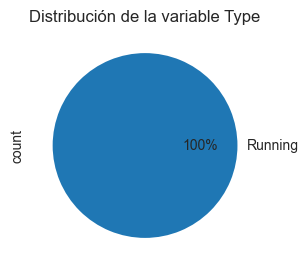

In [7]:
# Análisis de la variable Type
print(df['Type'].value_counts())

# Grafica de torta de la variable Type
plt.figure(figsize=(3, 3))
df['Type'].value_counts().plot.pie(autopct='%1.0f%%', startangle=180)
plt.title('Distribución de la variable Type')
plt.show()

Debido a que Type representa el tipo de actividad deportiva y en el presente análisis sólo se tienen registros de Running, en el proceso de limpieza se eliminará está columna ya que no aporta información valiosa para el modelo.

Name
Bogotá, D.C. Carrera                            19568
Running                                         15661
Coros workout                                   10873
Ciudad de Buenos Aires Carrera                   5984
Cali Carrera                                     5841
                                                ...  
Fusagasugá - 20min + 1x1 Fartlek                    1
Girardot - correr pista: 3x3000                     1
Chinchiná - Fartlek 1*1 20 Mins Correr 20:00        1
Chinchiná - Calentamiento Estándar 15 Mins          1
General López - 5x 800m                             1
Name: count, Length: 48958, dtype: int64


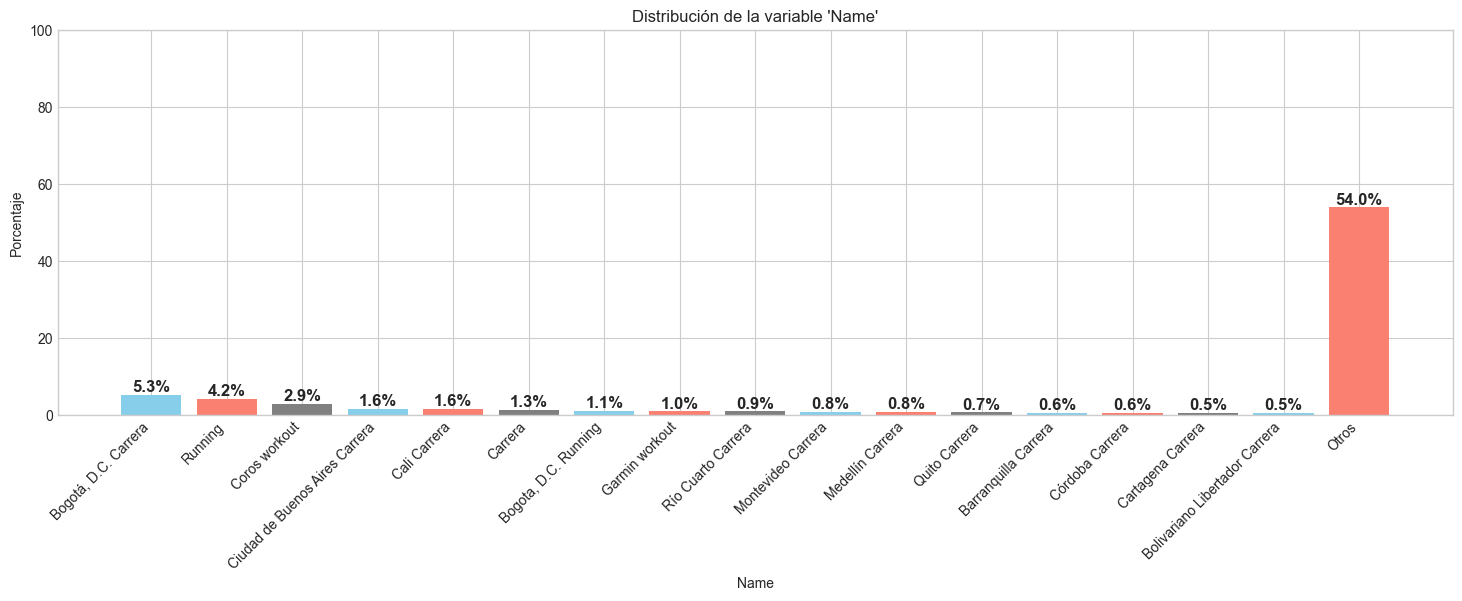

In [8]:
# Análisis de la variable Name
print(df['Name'].value_counts())

porcentajes = (df.value_counts('Name', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 0.5
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Name")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Name'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los nombres que representan al menos el 0.5% de los nombres encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización de los datos.

Esta variable representa el nombre de la actividad que le coloca el reloj o el usuario manualmente, esta variable no es relevante para el análisis por lo que en el proceso de limpieza se eliminará.

In [9]:
# Análisis de la variable StartTimeUtc
print(df['StartTimeUtc'].value_counts())

StartTimeUtc
2025-02-16 10:20:30.0000000 +00:00    11
2025-02-16 10:20:34.0000000 +00:00    10
2025-02-16 10:20:33.0000000 +00:00     9
2025-02-14 13:42:18.0000000 +00:00     7
2025-02-16 10:08:22.0000000 +00:00     7
                                      ..
2025-01-15 11:12:15.0000000 +00:00     1
2025-01-15 12:05:28.0000000 +00:00     1
2025-01-15 12:22:31.0000000 +00:00     1
2025-01-15 11:49:23.0000000 +00:00     1
2024-09-30 20:36:15.0000000 +00:00     1
Name: count, Length: 353228, dtype: int64


La variable StartTimeUtc representa la fecha y hora en la cual se inició la actividad, en los siguientes pasos se podría transformar en nuevas columnas que representen cada valor por separado para poder realizar un mejor análisis de su valor.

In [10]:
# Análisis de SourceType
print(df['SourceType'].value_counts())
(df.value_counts('SourceType', normalize=True) * 100).round(2).astype(str) + '%'

SourceType
Garmin    337921
Coros      12069
Polar      10620
Wahoo       4453
Suunto      4146
Apple        111
Name: count, dtype: int64


SourceType
Garmin    91.5%
Coros     3.27%
Polar     2.88%
Wahoo     1.21%
Suunto    1.12%
Apple     0.03%
Name: proportion, dtype: object

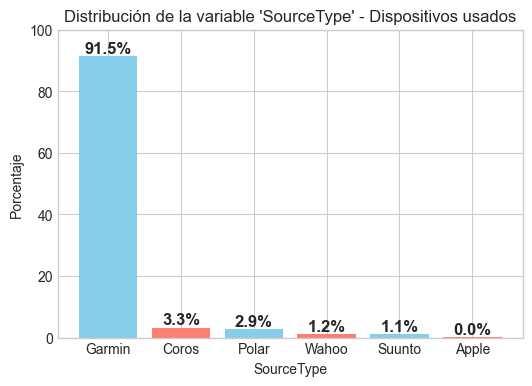

In [11]:
porcentajes = (df.value_counts('SourceType', normalize=True) * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(porcentajes.index, porcentajes, color=['skyblue', 'salmon'])

# Agregar las etiquetas
for bar, porcentaje in zip(bars, porcentajes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceType")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceType' - Dispositivos usados")
plt.ylim(0, 100)
plt.show()

En la gráfica anterior, se observa que Garmin domina ampliamente como la marca más utilizada. Esto podría introducir sesgos en el modelo, ya que la distribución está fuertemente inclinada hacia esta marca. Por ello, durante el proceso de limpieza, evaluaremos qué acciones tomar con esta variable, dado que el dataset muestra un claro desbalance.

In [12]:
# Análisis de la variable SourceName
print(df['SourceName'].value_counts())
(df.value_counts('SourceName', normalize=True) * 100).round(2).astype(str) + '%'

SourceName
Forerunner 55           28289
Forerunner 235          20019
Forerunner 245 Music    17401
Forerunner 965          16354
Forerunner 45           14867
                        ...  
Instinct Crossover          1
Wahoo ELEMNT RIVAL          1
fenix 6S Solar              1
Apple Watch Ultra           1
Approach S70 – 42mm         1
Name: count, Length: 242, dtype: int64


SourceName
Forerunner 55           7.68%
Forerunner 235          5.44%
Forerunner 245 Music    4.72%
Forerunner 965          4.44%
Forerunner 45           4.04%
                        ...  
Approach S70 – 42mm      0.0%
fenix 6S Solar           0.0%
Polar Grit X2 Pro        0.0%
Apple Watch Ultra        0.0%
Amazfit GTS 4 Mini       0.0%
Name: proportion, Length: 242, dtype: object

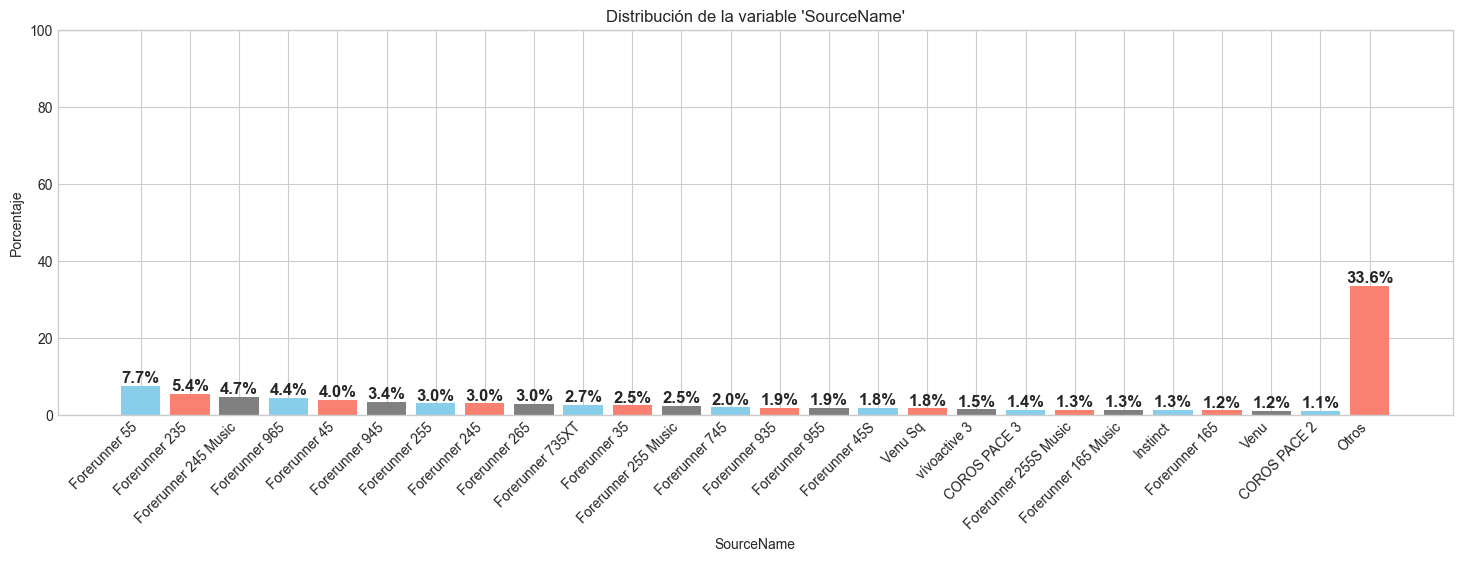

In [13]:
porcentajes = (df.value_counts('SourceName', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceName")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceName'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

En la anterior gráfica se enseñan algunos de los modelos que representan al menos el 1% de los modelos encontrados, en cualquier otro caso se agregarían a la categoría de otros para poder mejorar la visualización delos datos.

En el proceso de limpieza se podría evaluar si se podría eliminar la variable debido a que ya se encuentra representada en la varible sourceType, o se podría realizar algún tratamiento para representar de otra forma.

Warnings
DurationLessThanFiveMinutes                                       19889
DurationLessThanFiveMinutes - AveragePaceInMinutesPerKilometer     5632
TotalElevationGainInMeters                                         5249
AveragePaceInMinutesPerKilometer                                   1742
DurationLessThanFiveMinutes - TotalElevationGainInMeters           1696
                                                                  ...  
Overlapping:1910222                                                   1
Overlapping:1921511                                                   1
Overlapping:1925974                                                   1
Overlapping:1926488                                                   1
Overlapping:1351059                                                   1
Name: count, Length: 110, dtype: int64


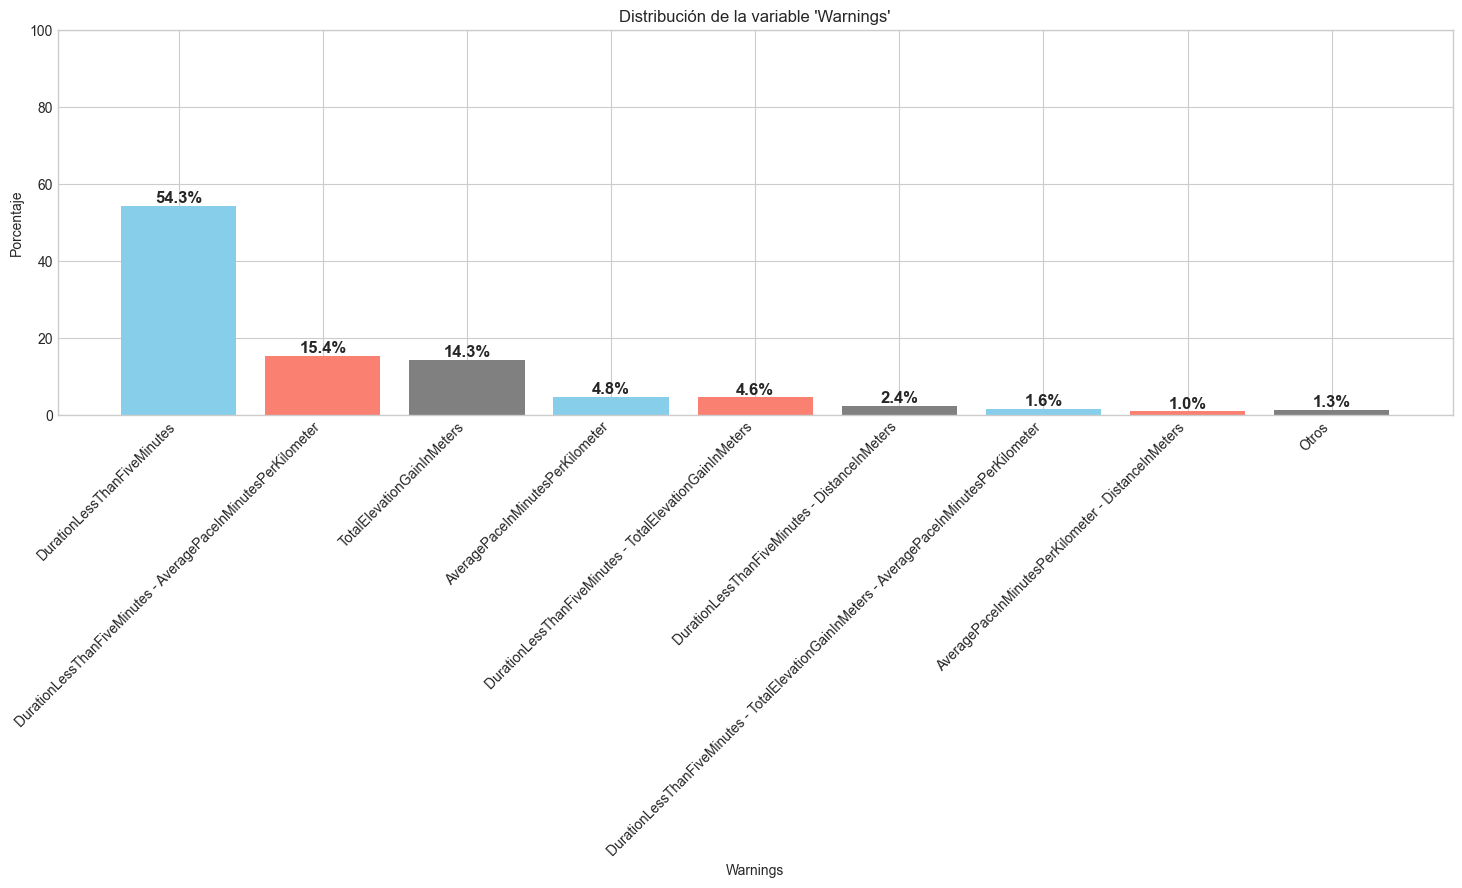

In [14]:
# Análisis de la variable Warnings
print(df['Warnings'].value_counts())

porcentajes = (df.value_counts('Warnings', normalize=True) * 100).round(2)

porcentajes.sort_values(ascending=False, inplace=True)

umbral = 1
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(18, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Warnings")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'Warnings'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

La variable warnings representa la clasificación manual que realiza la empresa para identificar datos atípicos basados en reglas del negocio, por esta razón en el proceso de limpieza se procederá a eliminar esta columna debido a que puede representar un data leakage y por lo tanto sesgaría el modelo.

In [15]:
# Análisis de la variable CreationTime
print(df['CreationTime'].value_counts())

CreationTime
2025-01-19 22:42:04.9000000 +00:00    3
2025-02-28 01:04:02.5733333 +00:00    2
2025-01-19 22:24:21.7966667 +00:00    2
2024-12-30 11:31:48.4336522 +00:00    2
2025-01-30 01:58:06.4000000 +00:00    2
                                     ..
2025-01-17 11:26:14.3290820 +00:00    1
2025-01-17 11:26:27.2548590 +00:00    1
2025-01-17 11:26:37.8747948 +00:00    1
2025-01-17 11:26:43.6745531 +00:00    1
2024-10-01 00:00:32.7421846 +00:00    1
Name: count, Length: 369314, dtype: int64


Al igual que la variable StartTimeUtc, la variable CreationTime representa una fecha; sin embargo, en este caso, indica la fecha y hora en que la actividad fue registrada en la base de datos de la empresa. Dado que esta información no aporta valor al análisis, se eliminará durante el proceso de limpieza.

Tratamiento de variables que inicialmente se determina no son relevantes para lograr el objetivo.
Se mantendrá una copia de df para mantener la información original y poder hacer comparaciones - df_original

In [16]:
# Eliminar Warnings porque puede presentarse data leakage
df = df.drop('Warnings', axis=1)

# Eliminar UserId porque el ID de un usuario no representa información relevante para el análisis
df = df.drop('UserId', axis=1)

# Eliminar Name representa el nombre de la actividad, pero no es relevante para el análisis
df = df.drop('Name', axis=1)

# Eliminar Type debido a que solo vamos a tomar los registros de Running por lo que solo habría una categoria en Type
df = df.drop('Type', axis=1)


# Convertir StartTimeUtc a hora local con el StartTimeOffsetInSeconds
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc']) + pd.to_timedelta(df['StartTimeOffsetInSeconds'], unit='s')

# Para el startTimeUtc decidimos dividir el valor en día, fecha, año y hora
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc'])

df['Year'] = df['StartTimeUtc'].dt.year
df['Month'] = df['StartTimeUtc'].dt.month
df['Day'] = df['StartTimeUtc'].dt.day
df['Hour'] = df['StartTimeUtc'].dt.hour

# Además agregamos una variable adicional que represente el día de la semana en el cual realizó el ejercicio (Donde 0 es lunes, 1 es martes, etc)
df['Day_of_week'] = df['StartTimeUtc'].dt.dayofweek

# Eliminar startTimeUtc
df = df.drop('StartTimeUtc', axis=1)

# Eliminar la variable CreationTime debido a que no es de valor para el análisis porque representa la fecha en la cual se registró la actividad en la base de datos
df = df.drop('CreationTime', axis=1)

# Eliminar la variable SourceType porque su información ya está contenida en SourceName y no aporta información adicional
df = df.drop('SourceName', axis=1)


# Convertir AveragePaceInMinutesPerKilometer a segundos por metro
df['AveragePaceInSecondsPerMeter'] = df['AveragePaceInMinutesPerKilometer'].apply(
    lambda x: (x * 60) / 1000 if x != 0 else 0)

# Eliminar AveragePaceInMinutesPerKilometer
df = df.drop('AveragePaceInMinutesPerKilometer', axis=1)

## Análisis de variables continuas


In [17]:
df_numericas = df.select_dtypes(include=['number'])
df_numericas.columns

Index(['DurationInSeconds', 'DistanceInMeters', 'Steps',
       'AverageSpeedInMetersPerSecond', 'TotalElevationGainInMeters',
       'TotalElevationLossInMeters', 'AverageHeartRateInBeatsPerMinute',
       'ActiveKilocalories', 'StartTimeOffsetInSeconds', 'Year', 'Month',
       'Day', 'Hour', 'Day_of_week', 'AveragePaceInSecondsPerMeter'],
      dtype='object')

In [18]:
df_numericas.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter
0,2281,5051.25,5938.0,2.214,NaN,NaN,148.0,293.0,-18000,2025,2,28,18,4,0.451671
1,1073,2332.04,3014.0,2.173,NaN,NaN,105.0,116.0,-14400,2025,2,28,18,4,0.460193
2,3126,9998.29,8826.0,3.198,19.986847,19.285492,137.0,652.0,-10800,2025,2,28,20,4,0.312695
3,1807,5245.36,5180.0,2.902,4.000000,8.000000,142.0,272.0,-14400,2025,2,28,18,4,0.344590
4,704,2006.97,1864.0,2.850,1.000000,9.000000,127.0,128.0,-18000,2025,2,28,18,4,0.350877


In [19]:
df_numericas.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter
count,3.693200e+05,3.682840e+05,365106.000000,368267.000000,334434.000000,334919.000000,355357.000000,367809.000000,369320.00000,369320.000000,369320.000000,369320.000000,369320.000000,369320.000000,368207.000000
mean,2.906427e+03,7.604707e+03,7284.166617,2.777340,130.506333,129.145907,140.584373,504.099000,-15493.79048,2024.411518,6.907877,15.698817,10.886852,3.039072,0.613695
std,4.101851e+03,6.664629e+03,6137.534811,2.474889,1924.532022,1933.900135,25.419308,420.630575,4915.15530,0.547250,4.702346,8.747534,5.475656,1.966062,24.624402
min,-1.764163e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-36000.00000,1991.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.325000e+03,3.290000e+03,2792.000000,2.358000,11.100000,11.000000,132.000000,212.000000,-18000.00000,2024.000000,2.000000,8.000000,6.000000,1.000000,0.317259
50%,2.583000e+03,6.722710e+03,6568.000000,2.751000,32.090000,32.460000,144.000000,437.000000,-18000.00000,2024.000000,10.000000,16.000000,8.000000,3.000000,0.363372
75%,3.764000e+03,1.009600e+04,10074.000000,3.150000,82.000000,83.759695,155.000000,688.000000,-10800.00000,2025.000000,11.000000,23.000000,17.000000,5.000000,0.424088
max,8.019640e+05,1.148765e+06,233553.000000,997.690002,784072.300000,783765.800000,239.000000,19123.000000,46800.00000,2025.000000,12.000000,31.000000,23.000000,6.000000,12550.000000


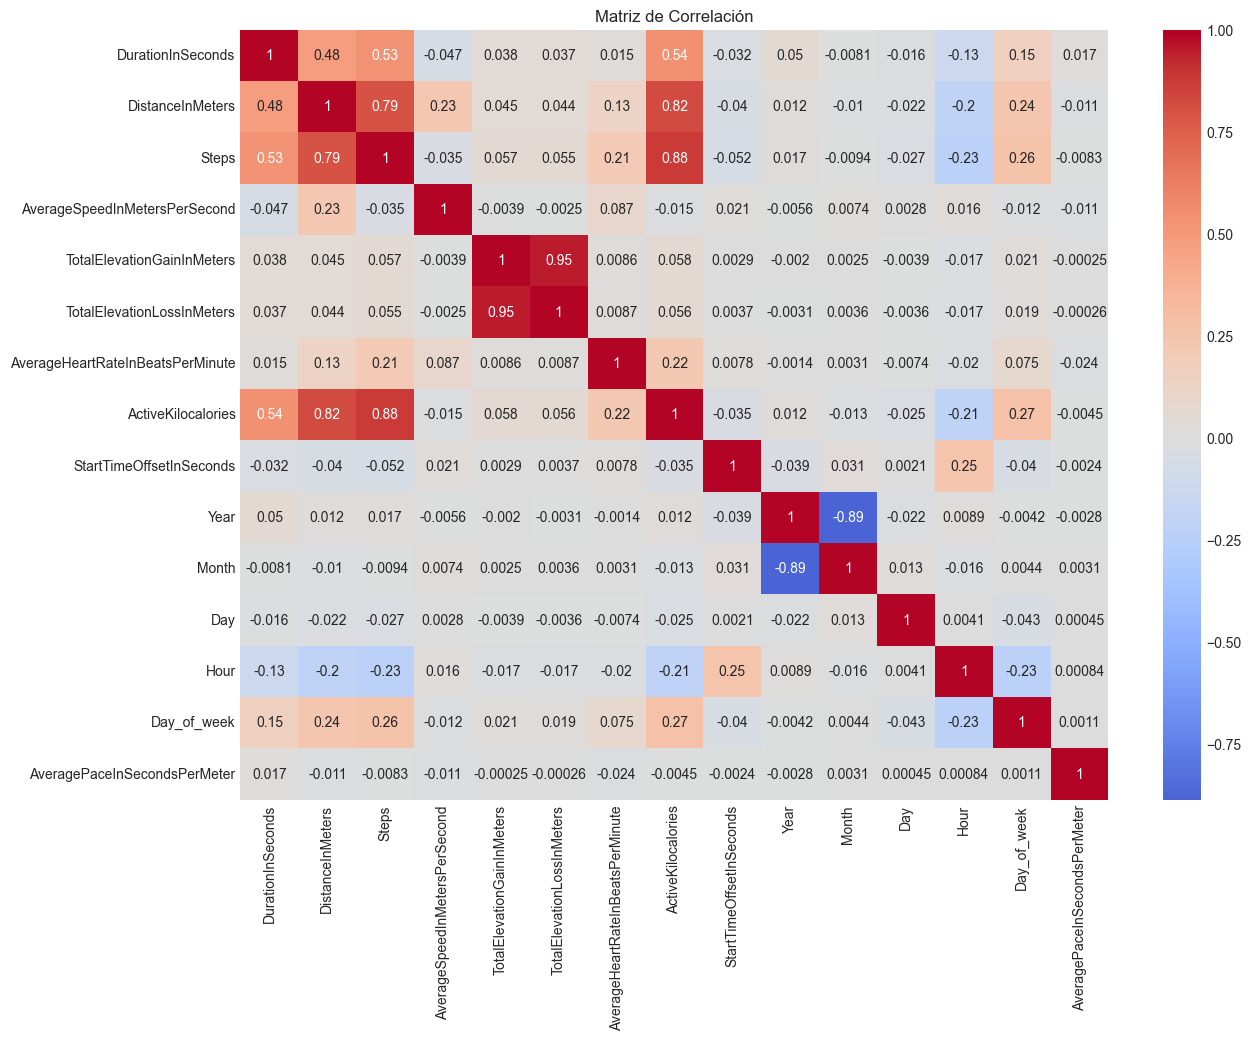

In [20]:
# Crear matriz de correlación
corr_matrix = df_numericas.corr()

# Heatmap de la matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


En la matriz de confusión se puede observar un alta correlación positiva entre las variables Steps y DistancesInMeters, Steps y ActiveKilocalories y DistanceInMeters y ActiveKilocalories por lo que se puede apreciar una posible relación lineal entre estas variables. Además se ve una correlación muy alta entre las variables TotalElevationGainInMeters y TotalElevationLossInMeters, está correlación alta puede mostrar una posible colinealidad debido a que ambas representan la misma variable pero medida en perdida o ganancia por lo que se deberá realizar algún tratamiento para evitar la colinealidad. Además, también se puede observar correlación positiva pero en menor medida entre Steps y DurationInSeconds, DistanceInMeters y DurationInSeconds. Las anteriores correlaciones positivas indican que si una variable aumenta la otra también.

In [21]:
integer_columns = df.select_dtypes(include=['int64']).columns
print("Variables enteras en el dataset:", integer_columns)


Variables enteras en el dataset: Index(['DurationInSeconds', 'StartTimeOffsetInSeconds'], dtype='object')


Podemos observar que la unicas variables que son enteras son la duración en segundos y el StartTimeOffsetInSeconds.

#### Análisis de DurationInSeconds

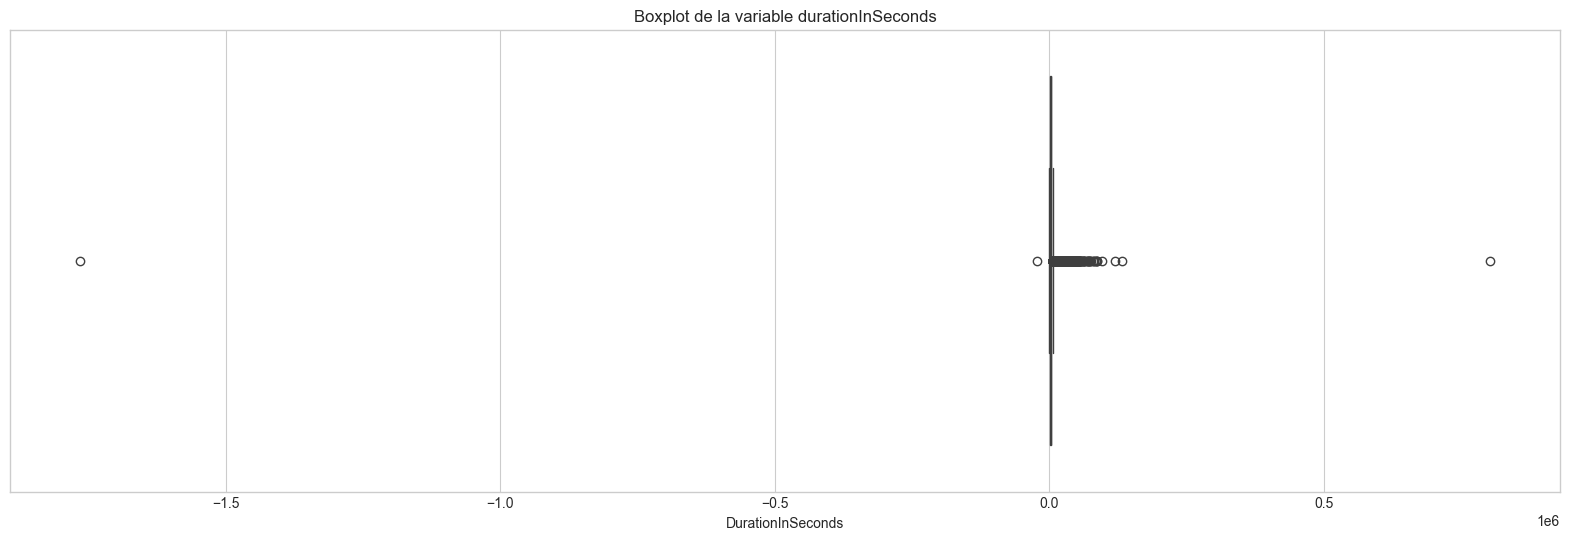

In [22]:
# Grafica de boxplot de  DurationInSeconds
plt.figure(figsize=(20, 6))
sns.boxplot(data=df, x='DurationInSeconds')
plt.title('Boxplot de la variable durationInSeconds')
plt.show()


Podemos observar que la variable de duración contiene valores negativos y valores iguales a cero. Además, se puede observar la presencia de datos atípicos que se salen de la media.

In [23]:
df['DurationInSeconds'].describe()

count    3.693200e+05
mean     2.906427e+03
std      4.101851e+03
min     -1.764163e+06
25%      1.325000e+03
50%      2.583000e+03
75%      3.764000e+03
max      8.019640e+05
Name: DurationInSeconds, dtype: float64

Tiempos nulos o negativos no tienen sentido práctico en nuestro análisis, así que se eliminarán del dataset

In [24]:
len(df[(df['DurationInSeconds']<=0)])

222

Se puede observar que se cuenta con 207 registros de duración en segundos menores o iguales a cero. Por lo que se procedera a eliminarlos:

In [25]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] > 0)]

In [26]:
df.shape

(369098, 16)

Para facilitar el análisis inicial se eliminarán los 2 registros que superan los 100000 segundos que representan más de 27 horas continuas.

In [27]:
len(df[(df['DurationInSeconds']>100000)])

3

In [28]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] < 100000)]

In [29]:
df.shape

(369095, 16)

In [30]:
df['DurationInSeconds'].describe()

count    369095.000000
mean       2910.180081
std        2560.495577
min           1.000000
25%        1329.000000
50%        2584.000000
75%        3765.000000
max       95739.000000
Name: DurationInSeconds, dtype: float64

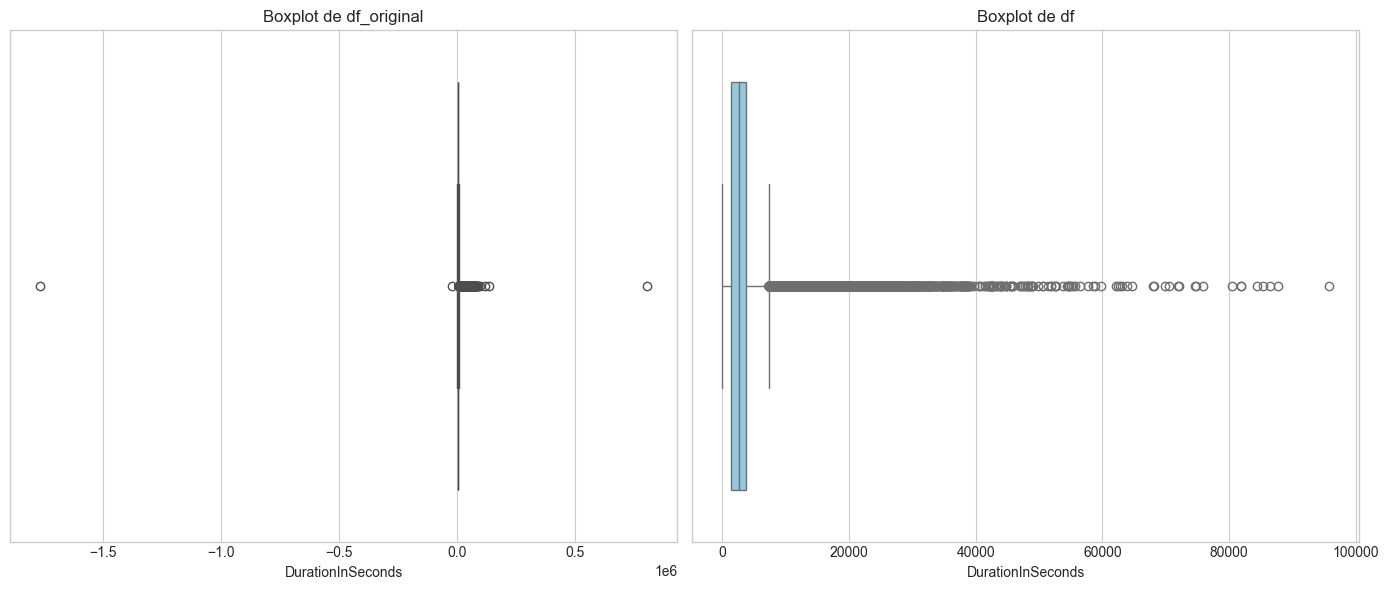

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

sns.boxplot(data=df_original, x='DurationInSeconds', color='orange', ax=axes[0])
axes[0].set_title('Boxplot de df_original')

sns.boxplot(data=df, x='DurationInSeconds', color='skyblue', ax=axes[1])
axes[1].set_title('Boxplot de df')

plt.tight_layout()
plt.show()

En el gráfico podemos observar que parece que hay muchos valores atípicos pero esto se debe a que una gran cantidad de registros tiene una duración muy corta.

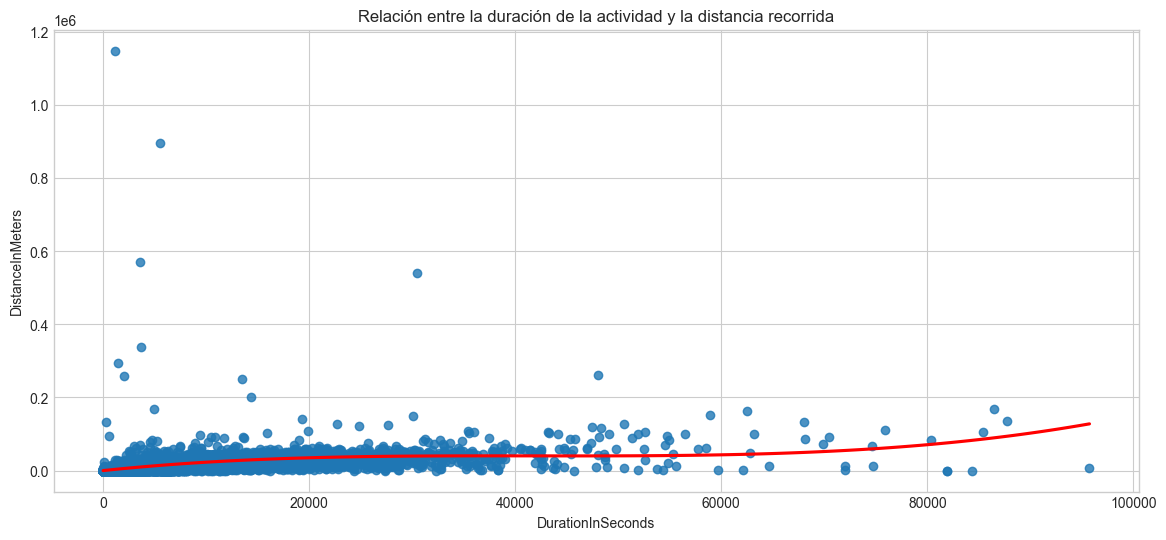

In [32]:
# Relación entre la duración de la actividad y la distancia recorrida con linea de regresion cuadratica
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='DistanceInMeters', order=3, ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y la distancia recorrida')
plt.show()

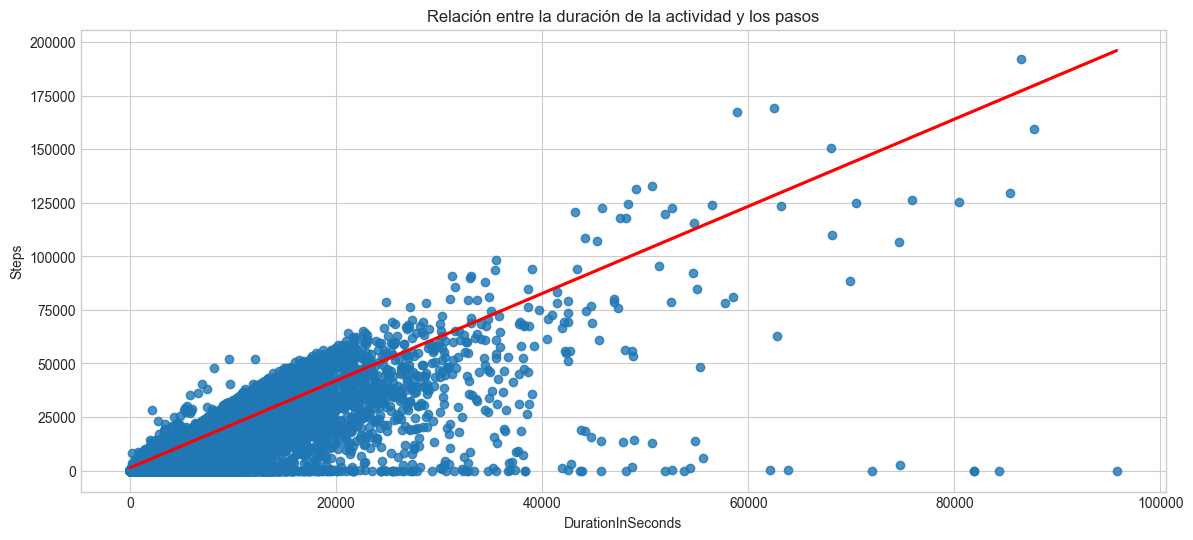

In [33]:
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DurationInSeconds', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la duración de la actividad y los pasos')
plt.show()

### Análisis de DistanceInMeters

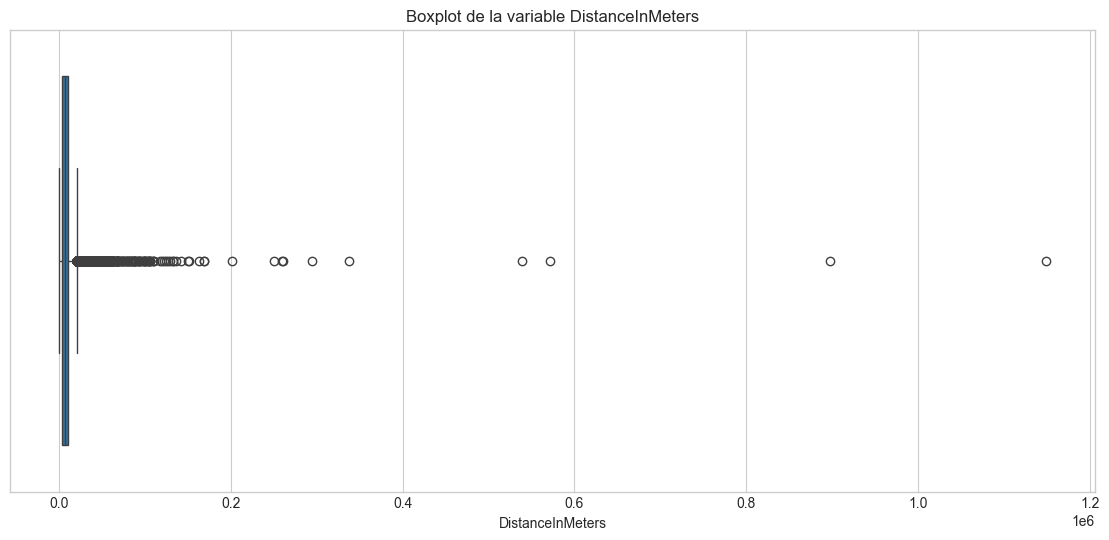

In [34]:
# Grafica de boxplot de DistanceInMeters
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='DistanceInMeters')
plt.title('Boxplot de la variable DistanceInMeters')
plt.show()

In [35]:
len(df[(df['DistanceInMeters']<=0)])

535


Esta variable tiene 508 registros menores o iguales a 0. Considerando que estamos analizando una actividad deportiva de tipo Running, registros sin distancia válida no serán útiles para el análisis

In [36]:
# Eliminar registros con distancia menor o igual a 0
df = df[(df["DistanceInMeters"] > 0)]

In [37]:
df.shape

(367626, 16)

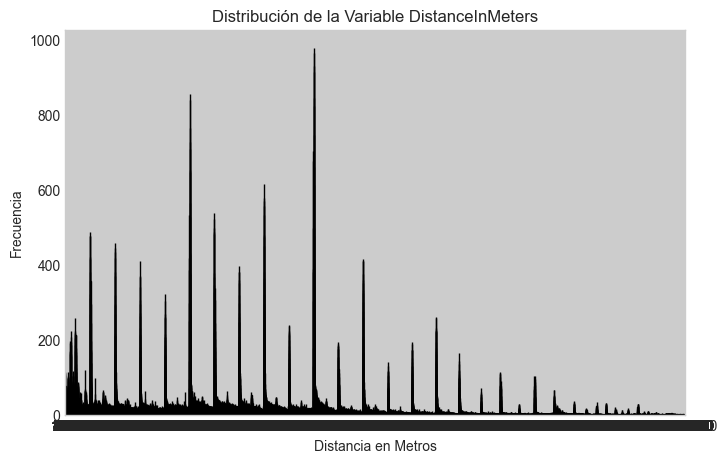

In [38]:
# Conteo de datos solo con números enteros para la variable DistanceInMeters. Esto solo con fines analíticos, no se afectará el dataset original
acumuladorDistancias = df['DistanceInMeters'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladorDistancias.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Distancia en Metros')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable DistanceInMeters')
plt.xticks(rotation=0)

plt.show()

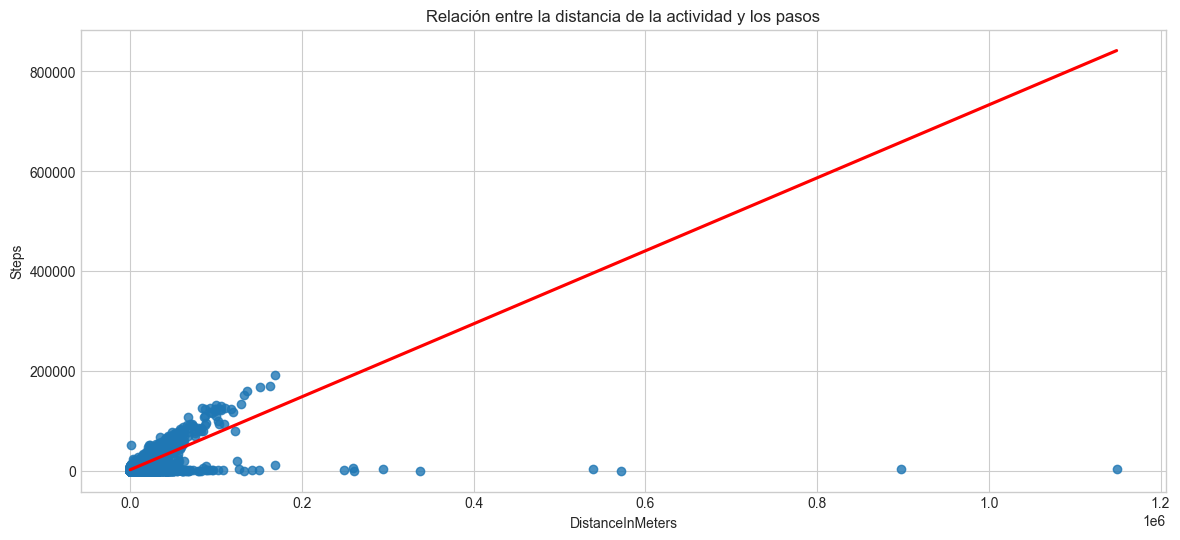

In [39]:
# Relación entre la distancia de la actividad y los pasos
plt.figure(figsize=(14, 6))
sns.regplot(data=df, x='DistanceInMeters', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre la distancia de la actividad y los pasos')
plt.show()

### Análisis de AverageSpeedInMetersPerSecond

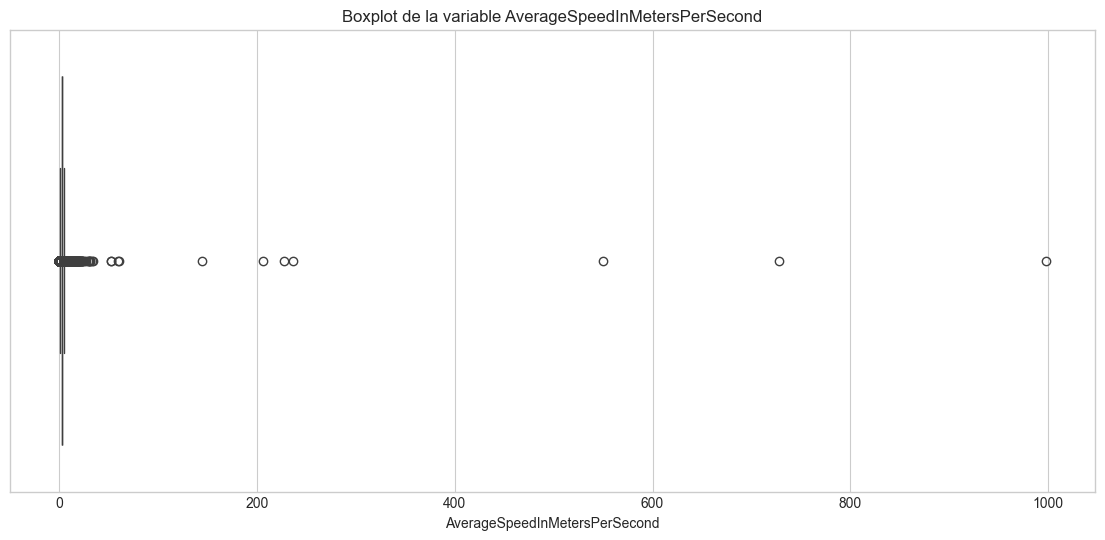

In [40]:
# Grafica de boxplot de AverageSpeedInMetersPerSecond
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AverageSpeedInMetersPerSecond')
plt.title('Boxplot de la variable AverageSpeedInMetersPerSecond')
plt.show()

In [41]:
# Cantidad de registros con velocidad promedio menor o igual a 0
len(df[(df['AverageSpeedInMetersPerSecond']<=0)])

16

Se pueden obsevar 16 registros de velocidad menores o iguales a cero por lo que se eliminarán debido a que no tendrían validez para el análisis realizado.

In [42]:
df = df[(df["AverageSpeedInMetersPerSecond"] > 0)]

### Análisis de AveragePaceInSecondsPerMeter

In [43]:
df['AveragePaceInSecondsPerMeter'].describe()

count    367607.000000
mean          0.548561
std           9.550295
min           0.001200
25%           0.317460
50%           0.363504
75%           0.424268
max        2250.000000
Name: AveragePaceInSecondsPerMeter, dtype: float64

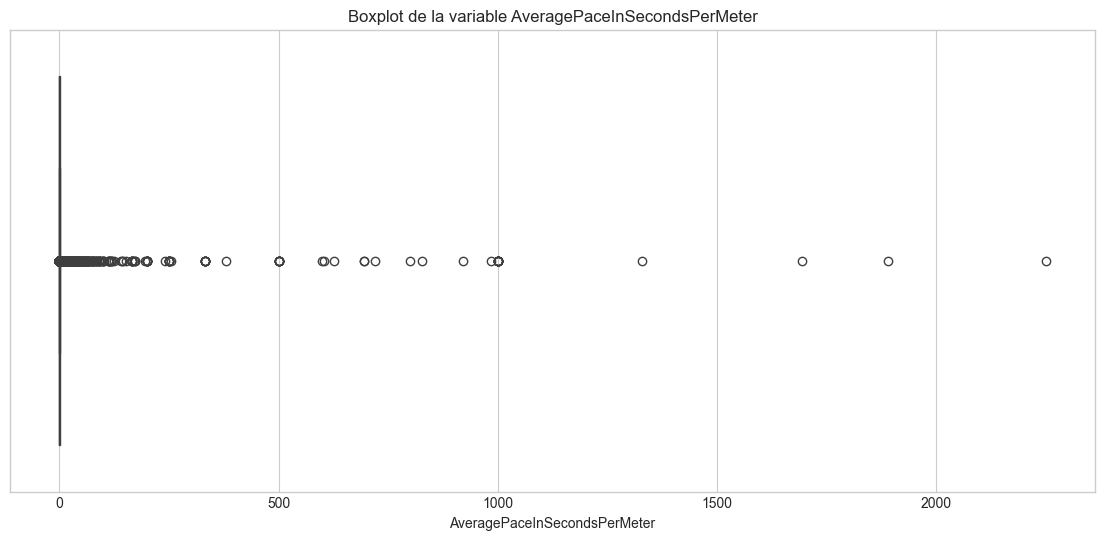

In [44]:
# Grafica de boxplot de AveragePaceInSecondsPerMeter
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='AveragePaceInSecondsPerMeter')
plt.title('Boxplot de la variable AveragePaceInSecondsPerMeter')
plt.show()

Para el caso del ritmo los valores atípicos se observan de dos formas, la primera cuando el ritmo es muy bajo debido a que entre menor sea el ritmo significa que la persona corre más rapido; por otro lado si el ritmo es muy alto significa que la persona esta caminando o esta en reposo.

In [45]:
# Cantidad de registros con ritmo promedio menor o igual a 0
len(df[(df['AveragePaceInSecondsPerMeter']<=0)])

0

### Análisis de TotalElevationGainInMeters y TotalElevationLossInMeters

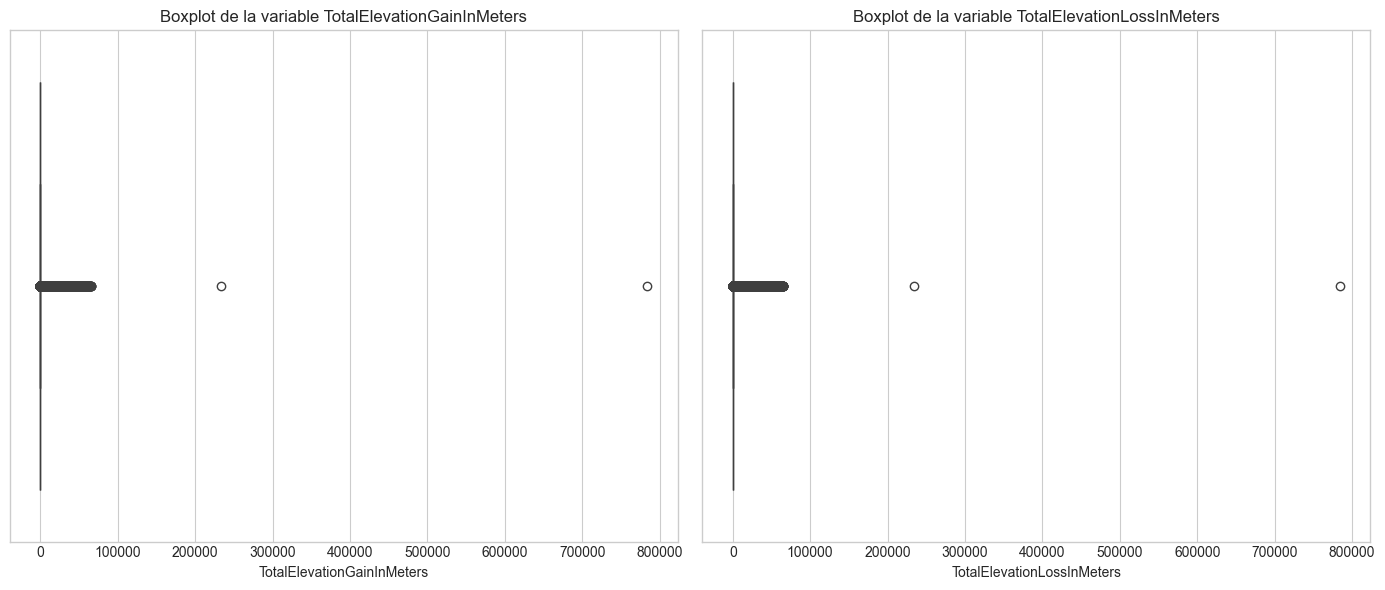

In [46]:
# Crear una figura con 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafica de boxplot de TotalElevationGainInMeters
sns.boxplot(data=df, x='TotalElevationGainInMeters', ax=axes[0])
axes[0].set_title('Boxplot de la variable TotalElevationGainInMeters')

# Grafica de boxplot de TotalElevationLossInMeters
sns.boxplot(data=df, x='TotalElevationLossInMeters', ax=axes[1])
axes[1].set_title('Boxplot de la variable TotalElevationLossInMeters')

# Ajustar el diseño para evitar superposición
plt.tight_layout()
plt.show()

Eliminar los 2 outliers que entorpecen el entendimiento de las variables TotalElevationGainInMeters y TotalElevationLossInMeters

In [47]:
print(len(df[(df["TotalElevationGainInMeters"] > 100000)]))
print(len(df[(df["TotalElevationLossInMeters"] > 100000)]))

2
2


In [48]:
df = df[~((df["TotalElevationGainInMeters"] > 100000) | (df["TotalElevationLossInMeters"] > 100000))]

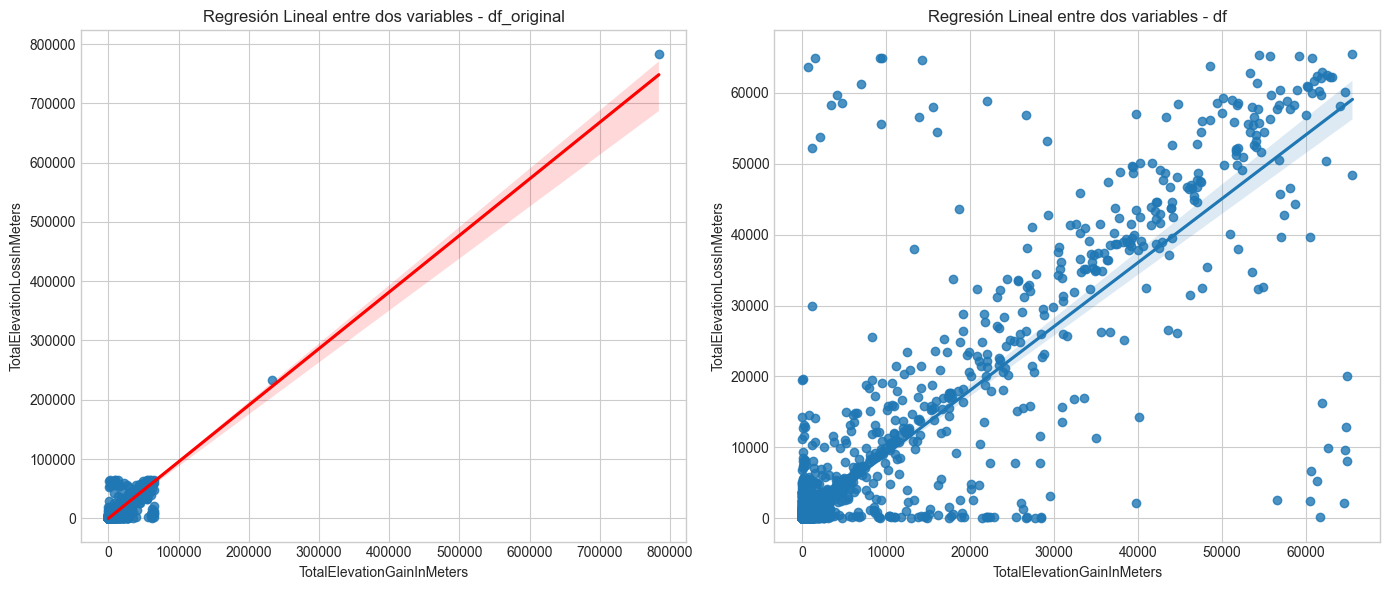

In [49]:
# Se analizará TotalElevationGainInMeters y TotalElevationLossInMeters debido a que presentan una correlación muy alta

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x=df_original["TotalElevationGainInMeters"], y=df_original["TotalElevationLossInMeters"], ax=axes[0], line_kws={'color':'red'})
axes[0].set_title('Regresión Lineal entre dos variables - df_original')

sns.regplot(x=df["TotalElevationGainInMeters"], y=df["TotalElevationLossInMeters"], ax=axes[1])
axes[1].set_title('Regresión Lineal entre dos variables - df')
plt.tight_layout()
plt.show()

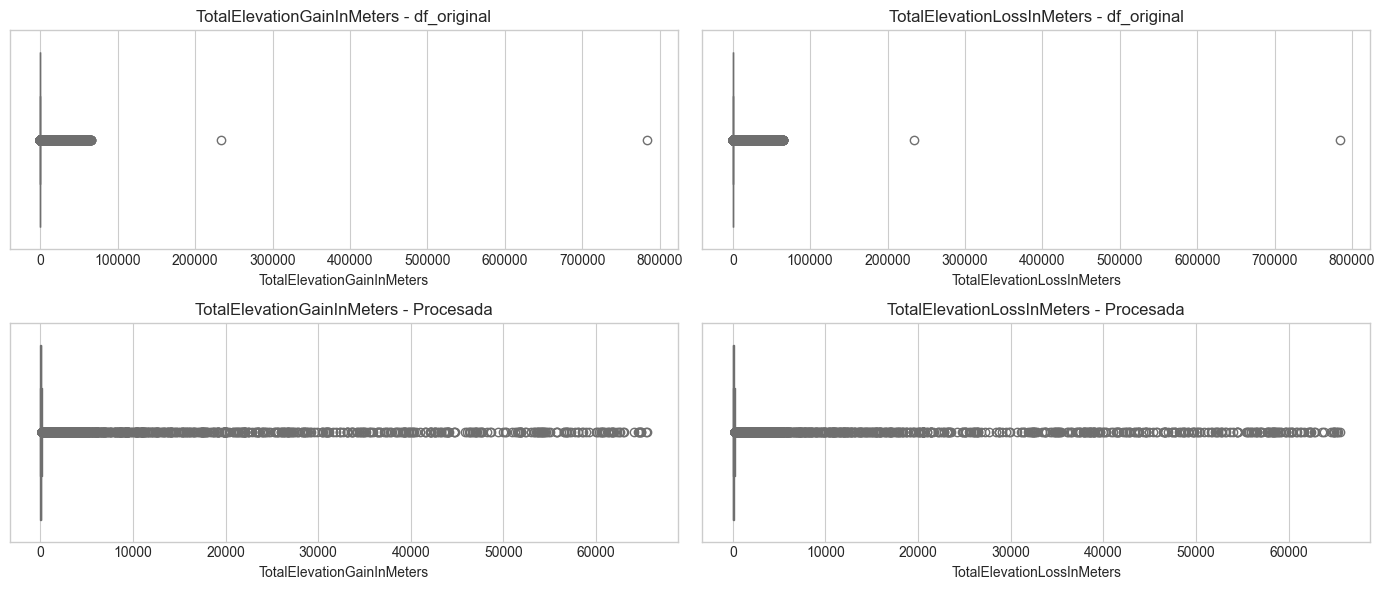

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
sns.boxplot(data=df_original, x='TotalElevationGainInMeters', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('TotalElevationGainInMeters - df_original')

sns.boxplot(data=df_original, x='TotalElevationLossInMeters', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('TotalElevationLossInMeters - df_original')

sns.boxplot(data=df, x='TotalElevationGainInMeters', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('TotalElevationGainInMeters - Procesada')

sns.boxplot(data=df, x='TotalElevationLossInMeters', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('TotalElevationLossInMeters - Procesada')

plt.tight_layout()
plt.show()

In [51]:
df['TotalElevationGainInMeters'].describe()

count    333766.000000
mean        127.279819
std        1302.363792
min           0.000000
25%          11.268249
50%          32.283451
75%          82.205020
max       65513.100000
Name: TotalElevationGainInMeters, dtype: float64

Debido a que las variables manejadas individualmente tiene un alto porcentaje de nulos:
TotalElevationGainInMeters: 33316 registros nulos
TotalElevationLossInMeters: 32925 registros nulos
Y se consideran importantes para el sistema de detección, se hace una transformación clasificando el terreno recorrido por el usuario como:
- **Flat**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
- **Uphill**: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
- **Downhill**: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
- **Mixed**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0

In [52]:
# Debido a que se observa un alta correlación entre ambas variables lo que nos indica que si se usan como predictoras para el modelo podemos tener problemas de colinealidad
"""
Se considera que la variable TotalElevationGainInMeters y TotalElevationLossInMeters aportan información relevante para el análisis,
por tanto se computará una columna adicional que represente el tipo de terreno en el cual se realizó la actividad
    1. Flat: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
    2. Uphill: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
    3. Downhill: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
    4. Mixed: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0
"""
df['TerrainType'] = 'Flat'  # Initialize with 'Flat'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] == 0), 'TerrainType'] = 'Uphill'
df.loc[(df['TotalElevationGainInMeters'] == 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Downhill'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Mixed'


# Eliminar las variables usadas para crear TerrainType
df = df.drop('TotalElevationGainInMeters', axis=1)
df = df.drop('TotalElevationLossInMeters', axis=1)

In [53]:
df.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,SourceType,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType
0,2281,5051.25,5938.0,2.214,148.0,Garmin,293.0,-18000,2025,2,28,18,4,0.451671,Flat
1,1073,2332.04,3014.0,2.173,105.0,Garmin,116.0,-14400,2025,2,28,18,4,0.460193,Flat
2,3126,9998.29,8826.0,3.198,137.0,Garmin,652.0,-10800,2025,2,28,20,4,0.312695,Mixed
3,1807,5245.36,5180.0,2.902,142.0,Garmin,272.0,-14400,2025,2,28,18,4,0.344590,Mixed
4,704,2006.97,1864.0,2.850,127.0,Garmin,128.0,-18000,2025,2,28,18,4,0.350877,Mixed


DistanceInMeters                                           \
                       count         mean          std   min      25%   
TerrainType                                                             
Downhill              2621.0  4441.333997  3688.555923  2.00  1347.09   
Flat                 53346.0  2998.820318  6598.948984  0.01   400.00   
Mixed               309411.0  8454.439084  6319.464687  2.61  4883.26   
Uphill                2227.0  5545.234252  5167.809274  3.00  1596.69   

                                                 DurationInSeconds  \
                     50%         75%         max             count   
TerrainType                                                          
Downhill     3498.980000   6544.0000    25013.00            2621.0   
Flat         1094.840000   4195.6675  1148765.00           53346.0   
Mixed        7516.899902  10606.5150   897198.75          309411.0   
Uphill       4772.000000   8065.1100    67343.49            2227.0   

                          ... AverageSpeedInMetersPerSecond              \
                    mean  ...                           75%         max   
TerrainType               ...                                             
Downhill     1673.465853  ...                        3.1850    8.173000   
Flat         1201.656075  ...                        3.6890  997.690002   
Mixed        3227.231317  ...                        3.1060  549.888000   
Uphill       2143.582398  ...                        3.0915   14.273000   

            AverageHeartRateInBeatsPerMinute                              \
                                       count        mean        std  min   
TerrainType                                                                
Downhill                              2612.0  138.426876  24.796074  0.0   
Flat                                 49298.0  126.278267  41.662807  0.0   
Mixed                               299952.0  143.343568  19.617103  0.0   
Uphill                                2206.0  134.514506  37.811593  0.0   

                                         
               25%    50%    75%    max  
TerrainType                              
Downhill     127.0  141.0  153.0  186.0  
Flat         119.0  137.0  150.0  239.0  
Mixed        134.0  145.0  156.0  232.0  
Uphill       127.0  144.0  156.0  198.0  

[4 rows x 32 columns]

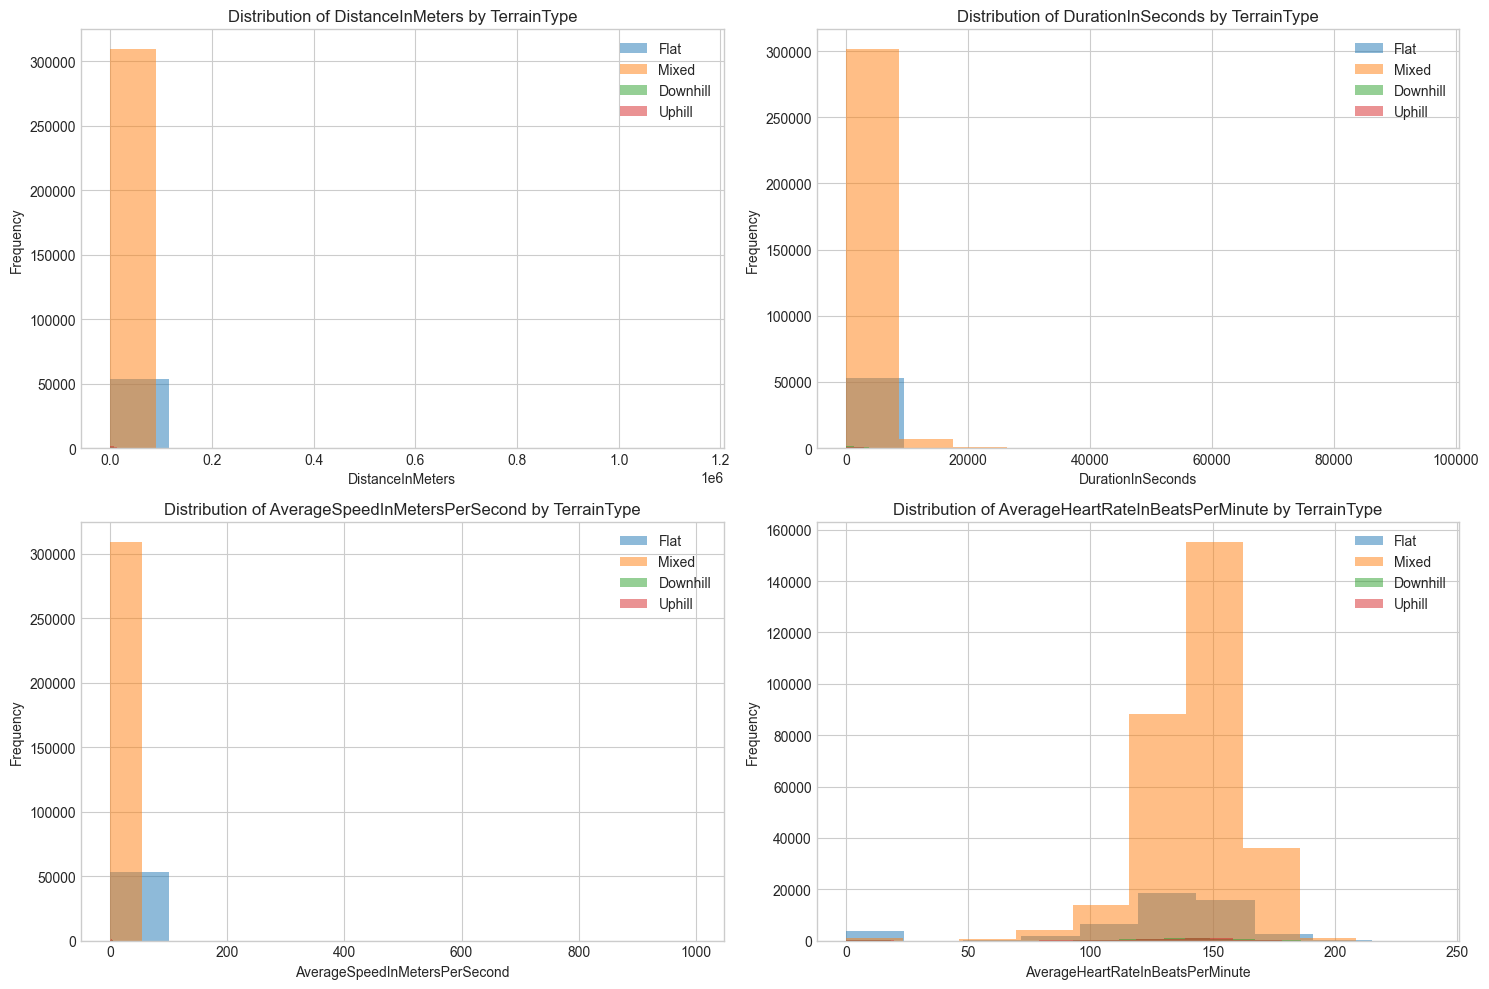

In [54]:
# Numerical variables to analyze
numerical_cols = ['DistanceInMeters', 'DurationInSeconds', 'AverageSpeedInMetersPerSecond', 'AverageHeartRateInBeatsPerMinute']

# 1. Descriptive statistics grouped by TerrainType
descriptive_stats = df.groupby('TerrainType')[numerical_cols].describe()
display(descriptive_stats)

# 2. Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    for terrain_type in df['TerrainType'].unique():
        plt.hist(df[df['TerrainType'] == terrain_type][col].dropna(), alpha=0.5, label=terrain_type)
    plt.title(f'Distribution of {col} by TerrainType')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


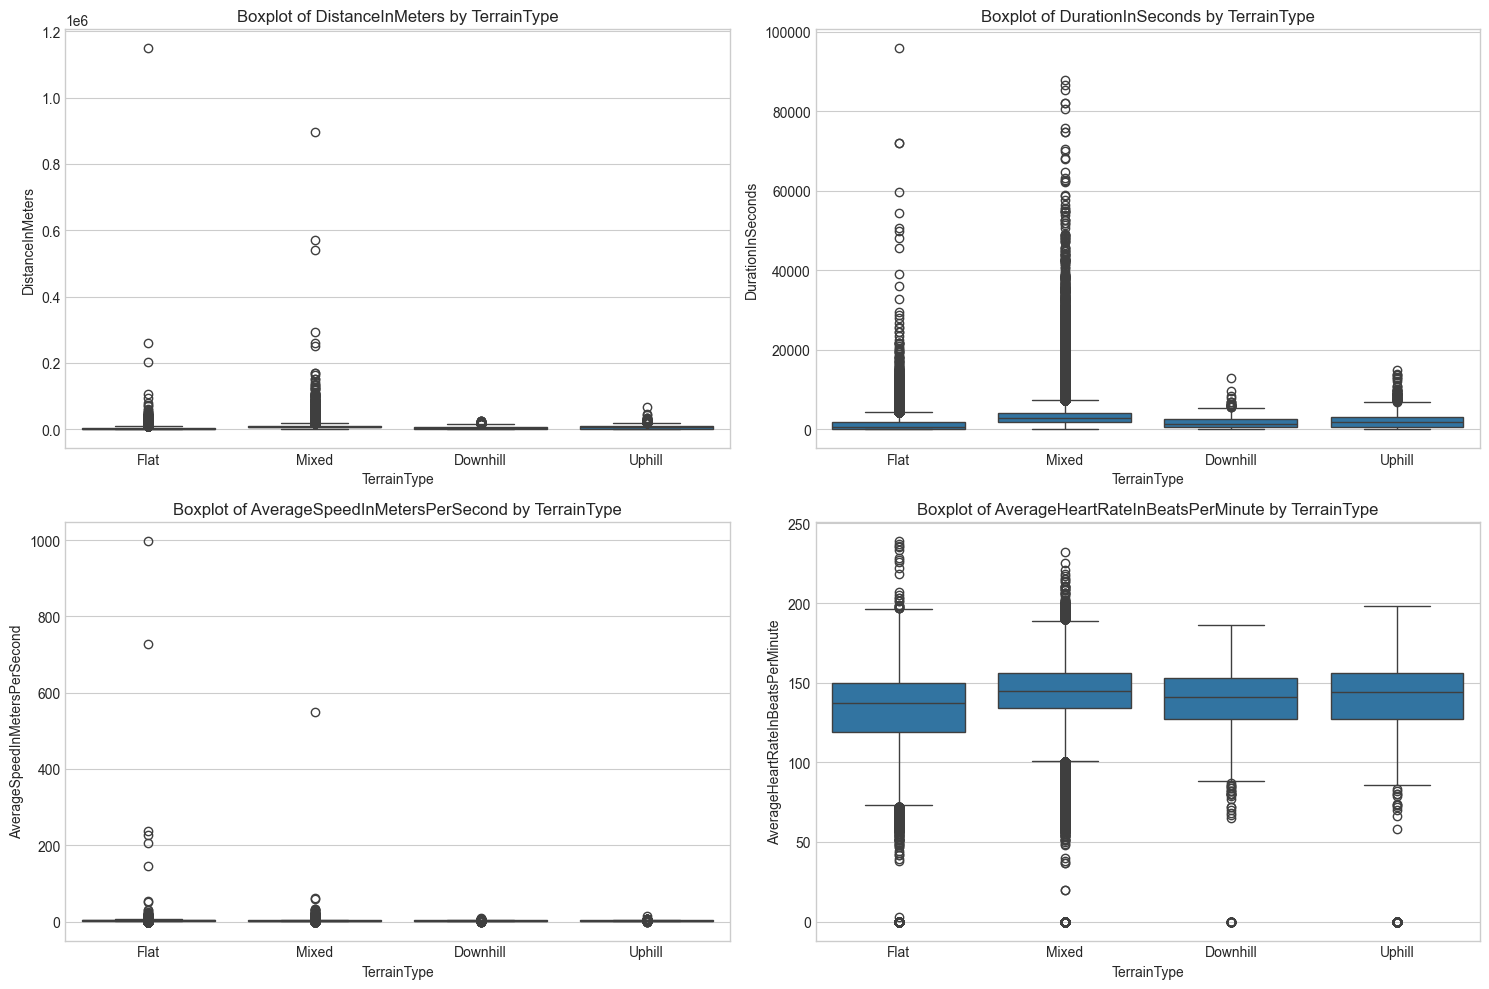

In [55]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='TerrainType', y=col, data=df)
    plt.title(f'Boxplot of {col} by TerrainType')
plt.tight_layout()
plt.show()


En los Boxplot se evidencia que con la clasificación de TerrainType en 4 categorías: Flat, Uphill, Downhill y Mixed, se observa que los terrenos Mixed y Flat presentan una mayor probabilidad de contener datos atípicos en cada una de las variables.

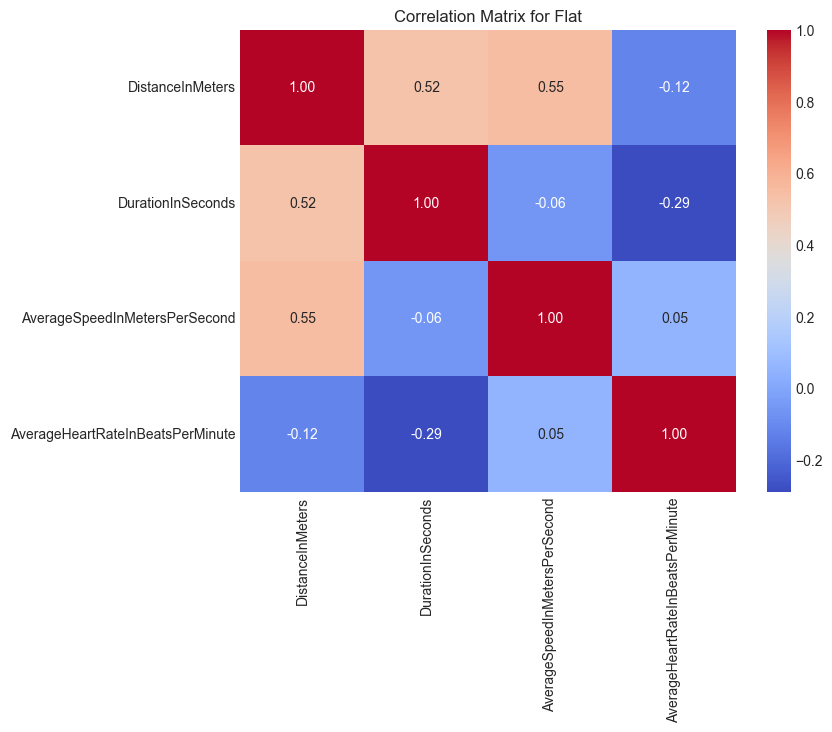

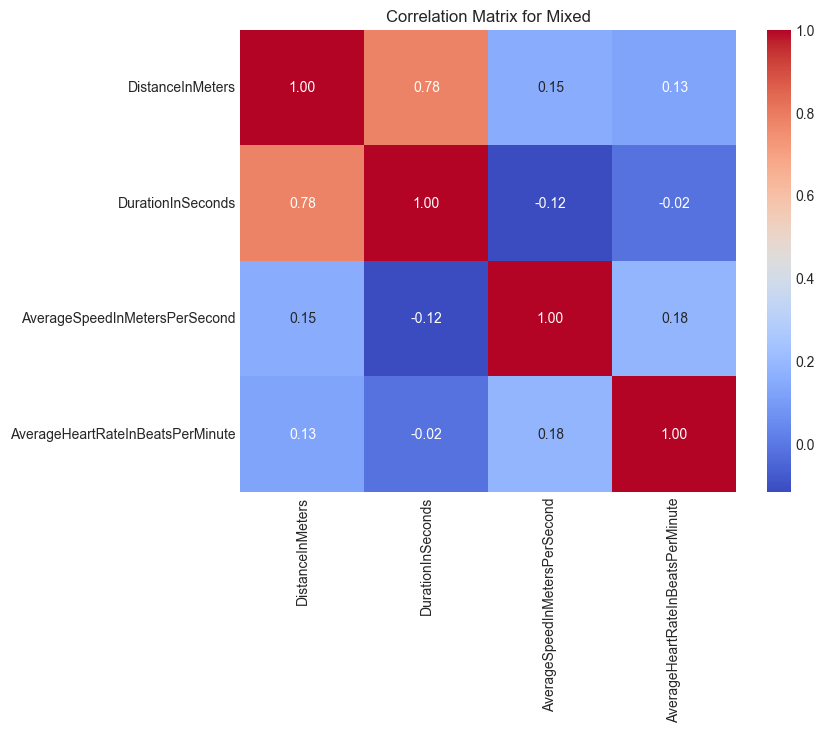

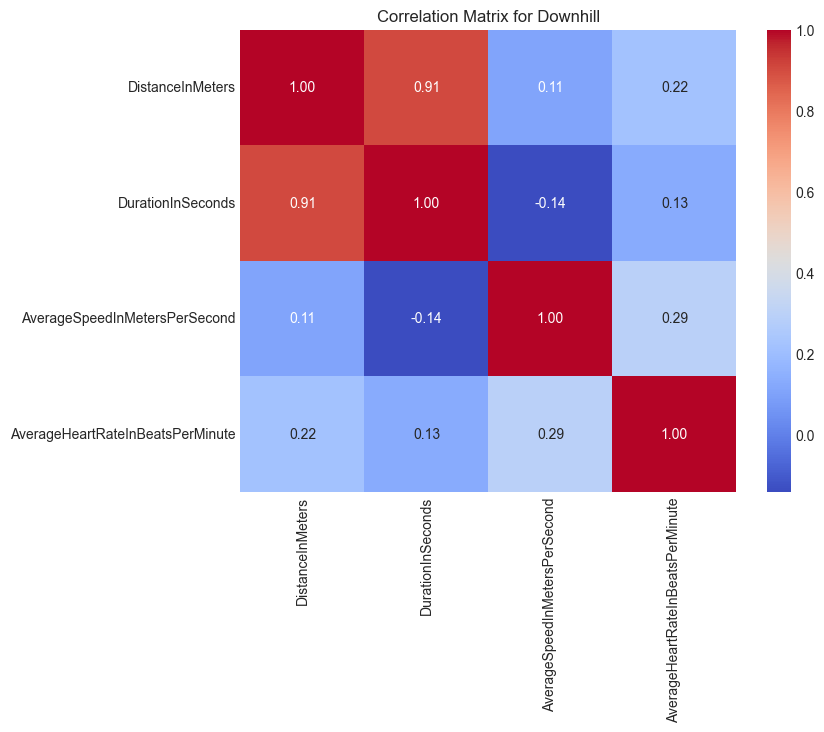

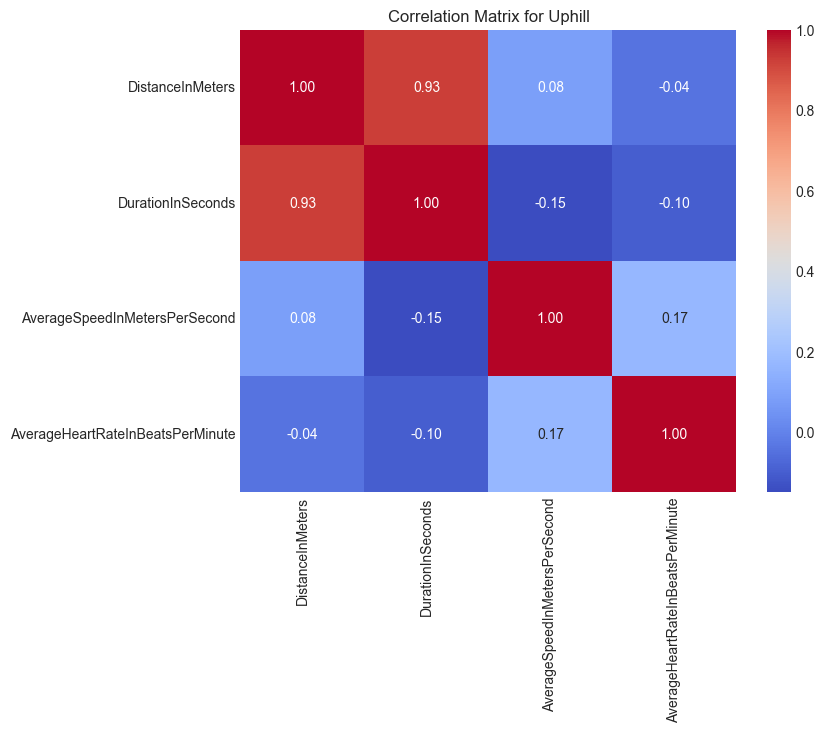

In [56]:
# 3. Correlation matrices and heatmaps
for terrain_type in df['TerrainType'].unique():
    terrain_data = df[df['TerrainType'] == terrain_type]
    correlation_matrix = terrain_data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {terrain_type}')
    plt.show()

### Análisis de AverageHeartRateInBeatsPerMinute

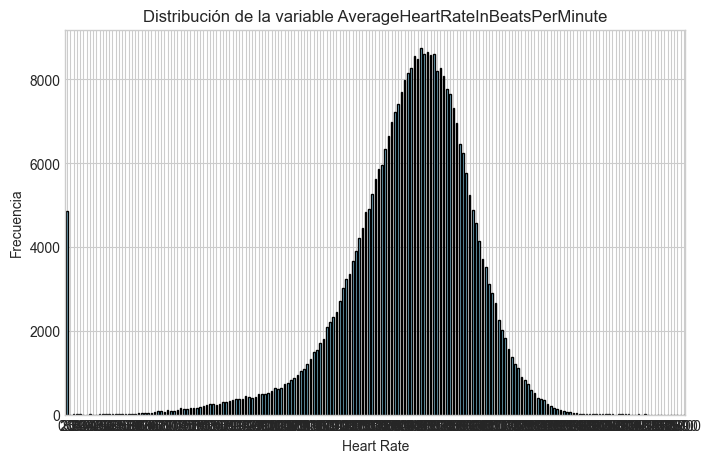

In [57]:
# Contenteo de datos solo con números enteros para la variable AverageHeartRateInBeatsPerMinute. Esto solo con fines analíticos, no se afectará el dataset original
acumuladoRate = df['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Heart Rate')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable AverageHeartRateInBeatsPerMinute')
plt.xticks(rotation=0)

plt.show()

In [58]:
len(df[(df['AverageHeartRateInBeatsPerMinute']==0)])

4856

In [59]:
df_encoded = pd.get_dummies(df, columns=['TerrainType','SourceType'])
df_encoded.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,...,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo
0,2281,5051.25,5938.0,2.214,148.0,293.0,-18000,2025,2,28,...,False,True,False,False,False,False,True,False,False,False
1,1073,2332.04,3014.0,2.173,105.0,116.0,-14400,2025,2,28,...,False,True,False,False,False,False,True,False,False,False
2,3126,9998.29,8826.0,3.198,137.0,652.0,-10800,2025,2,28,...,False,False,True,False,False,False,True,False,False,False
3,1807,5245.36,5180.0,2.902,142.0,272.0,-14400,2025,2,28,...,False,False,True,False,False,False,True,False,False,False
4,704,2006.97,1864.0,2.850,127.0,128.0,-18000,2025,2,28,...,False,False,True,False,False,False,True,False,False,False


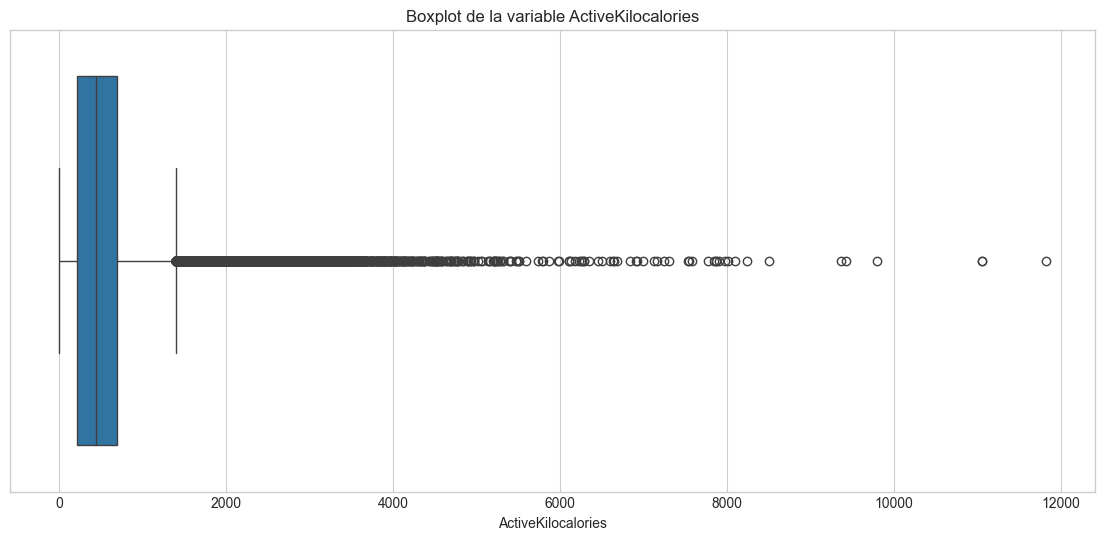

In [60]:
# Análisis de ActiveKilocalories

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_encoded, x='ActiveKilocalories')
plt.title('Boxplot de la variable ActiveKilocalories')
plt.show()

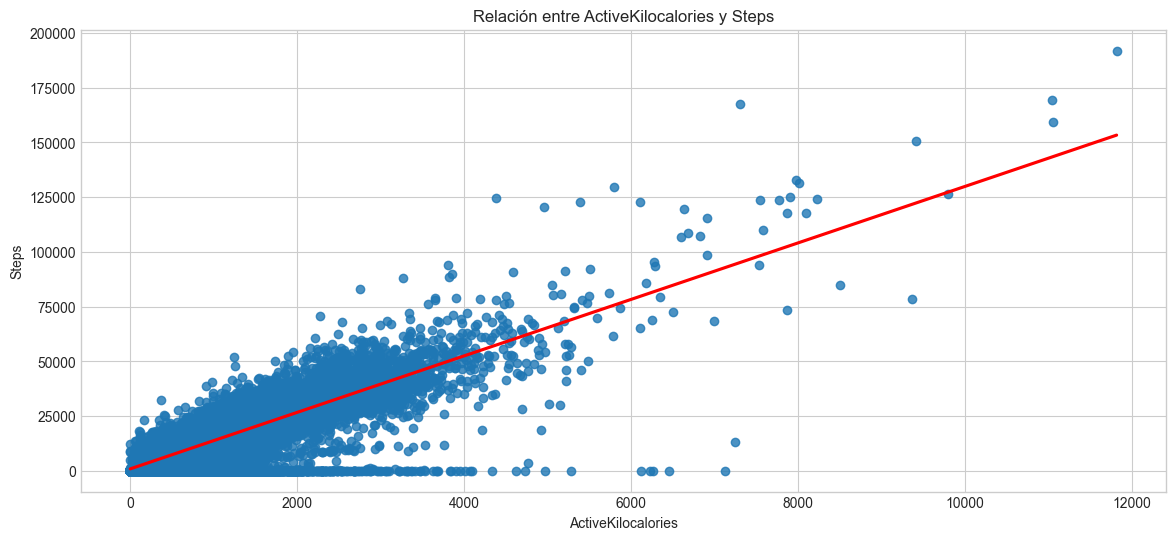

In [61]:
# Grafica de ActiveKilocalories vs Steps
plt.figure(figsize=(14, 6))
sns.regplot(data=df_encoded, x='ActiveKilocalories', y='Steps', ci=None, line_kws={'color':'red'})
plt.title('Relación entre ActiveKilocalories y Steps')
plt.show()

In [62]:
columnas_para_imputacion = [
    'DurationInSeconds',
    'DistanceInMeters',
    'Steps',
    'AverageSpeedInMetersPerSecond',
    'Day',
    'TerrainType_Downhill',
    'TerrainType_Flat',
    'TerrainType_Mixed',
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute',
    'ActiveKilocalories'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)
df_encoded['Steps'] = df_encoded['Steps'].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=5)
df_encoded[columnas_para_imputacion] = imputer.fit_transform(df_encoded[columnas_para_imputacion])
df_encoded.describe()


,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,367605.000000,3.676050e+05,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000
mean,2915.641316,7.616495e+03,7610.827347,2.781592,142.407287,503.708161,-15490.765088,2024.411893,6.907553,15.696511,10.882899,3.038832,0.548559,0.007130,0.145118,0.841694,0.006058
std,2553.367409,6.631341e+03,6036.627109,2.473989,18.864459,418.867914,4917.072626,0.540887,4.702511,8.746821,5.473947,1.965770,9.550321,0.084138,0.352220,0.365028,0.077598
min,1.000000,1.000000e-02,1.000000,0.001000,3.000000,0.000000,-36000.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.001200,0.000000,0.000000,0.000000,0.000000
25%,1342.000000,3.318820e+03,3420.000000,2.360000,132.000000,212.000000,-18000.000000,2024.000000,2.000000,8.000000,6.000000,1.000000,0.317460,0.000000,0.000000,1.000000,0.000000
50%,2589.000000,6.741880e+03,6840.000000,2.752000,145.000000,437.000000,-18000.000000,2024.000000,10.000000,16.000000,8.000000,3.000000,0.363504,0.000000,0.000000,1.000000,0.000000
75%,3768.000000,1.009930e+04,10242.000000,3.151000,155.000000,688.000000,-10800.000000,2025.000000,11.000000,23.000000,17.000000,5.000000,0.424268,0.000000,0.000000,1.000000,0.000000
max,95739.000000,1.148765e+06,192006.000000,997.690002,239.000000,11821.000000,46800.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,2250.000000,1.000000,1.000000,1.000000,1.000000


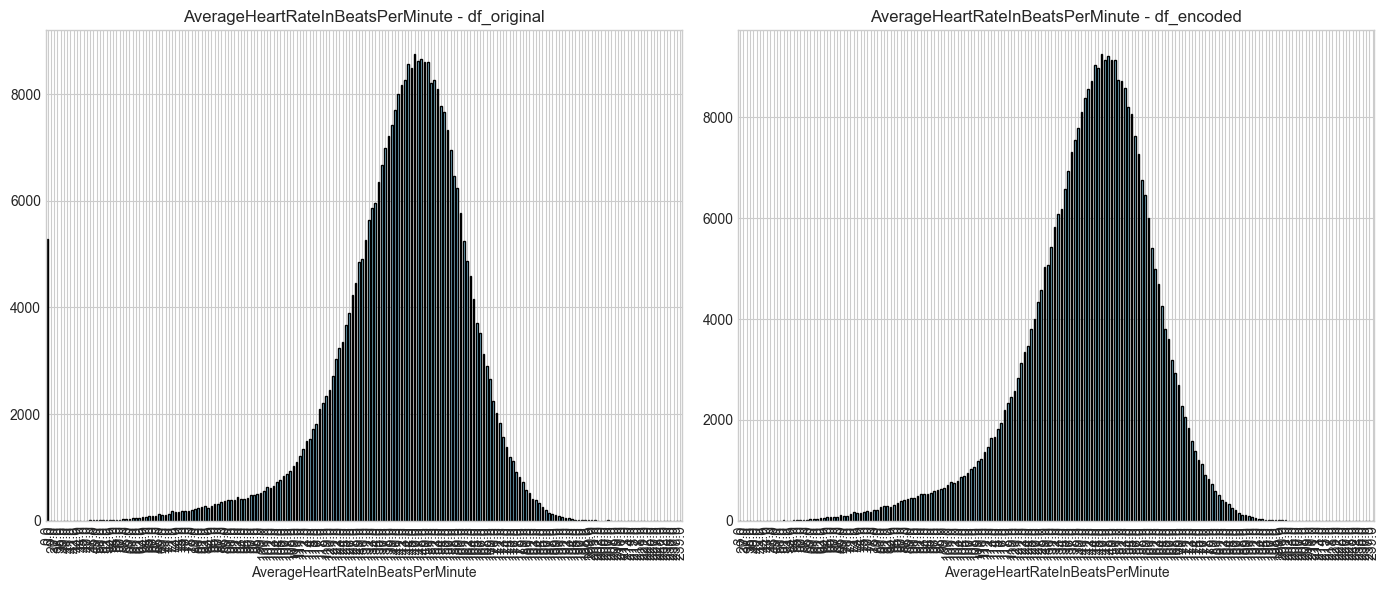

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
acumuladoRate = df_original['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('AverageHeartRateInBeatsPerMinute - df_original')

acumuladoRate = df_encoded['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('AverageHeartRateInBeatsPerMinute - df_encoded')
plt.tight_layout()
plt.show()

### Análisis de Outliers

* DistanceInMeters: Distancia recorrida durante la actividad, expresada en metros.
* AverageHeartRateInBeatsPerMinute: Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (BPM).
* AveragePaceInMinutesPerKilometer: Ritmo promedio de la actividad, expresado en minutos por kilómetro.


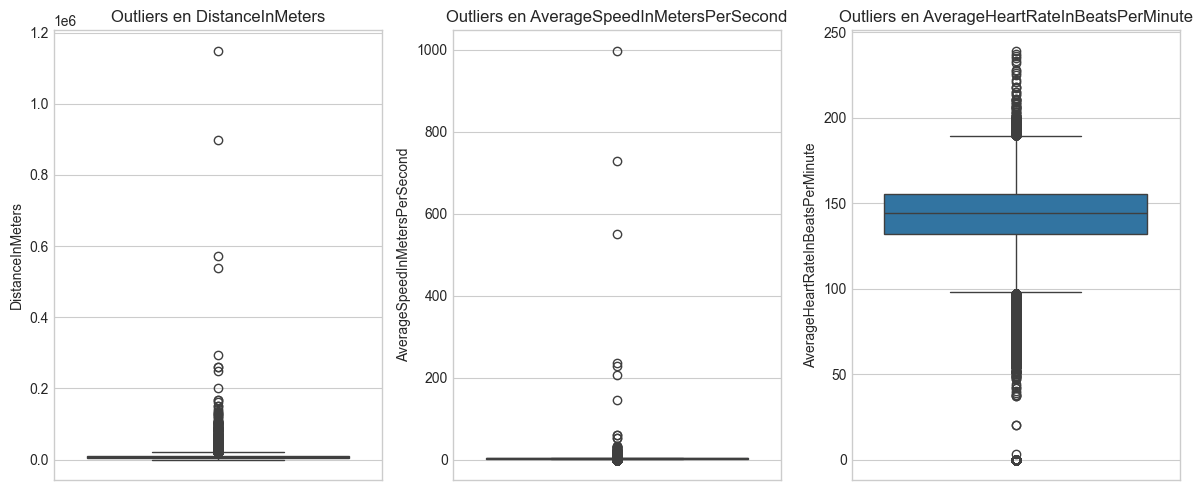

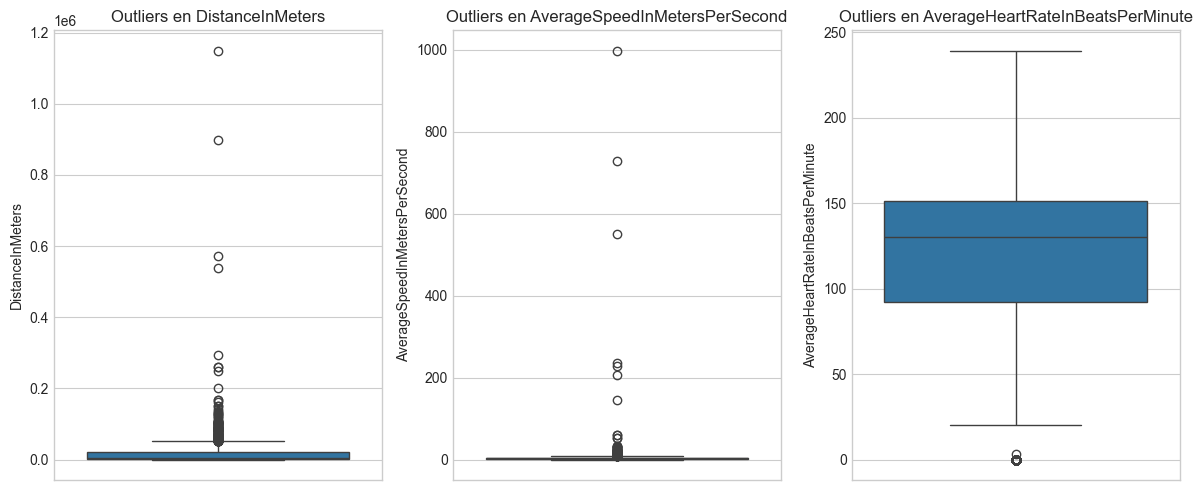

In [64]:
outlier_cols = ["DistanceInMeters", "AverageSpeedInMetersPerSecond", "AverageHeartRateInBeatsPerMinute"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

# Detección de outliers con el método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Crear boxplots solo con los outliers
df_outliers = pd.DataFrame()
for col in outlier_cols:
    df_outliers = pd.concat([df_outliers, detect_outliers_iqr(df, col)])

df_outliers = df_outliers.drop_duplicates()

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_outliers[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

### Conclusiones de análisis exploratorio

1. Reveló la existencia de datos inconsistentes como valores nulos, negativos o ceros en variables como DurationInSeconds, DistanceInMeters, AverageSpeedInMetersPerSecond y AverageHeartRateInBeatsPerMinute. Además, se identificaron valores atípicos (outliers) en variables como DistanceInMeters, AverageSpeedInMetersPerSecond y AverageHeartRateInBeatsPerMinute, lo que indica posibles errores de medición, actividades sospechosas

2. Se observó un desbalance significativo en la variable SourceType, donde la marca Garmin domina ampliamente como la fuente de datos. Esto podría introducir sesgos en el modelo, ya que la distribución está fuertemente inclinada hacia esta marca.

3. Se identificaron correlaciones entre diversas variables, como Steps y DistanceInMeters, Steps y ActiveKilocalories, DistanceInMeters y ActiveKilocalories, TotalElevationGainInMeters y TotalElevationLossInMeters, Steps y DurationInSeconds, y DistanceInMeters y DurationInSeconds. Estas correlaciones son esperables en el contexto de actividades de running, pero es importante considerarlas durante la selección de características para el modelo, ya que la colinealidad entre variables puede afectar la precisión del modelo.

# Limpieza de datos

Al final del proceso de exploración se realizó la limpieza, transformación e imputación de los datos por lo que en la siguiente sección se enseña cómo quedó el dataset después de este proceso.

### Revisión del df resultante después del análisis de variables inicial

In [65]:
df_encoded.shape

(367605, 23)

Los datos originales eran (351195, 16), lo que quiere decir que a nivel de registros se han eliminado 1627 lo que representa el 0.46% de los datos. Y se aumentó la cantidad de columnas a 21.

In [66]:
df_encoded.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,Hour,Day_of_week,AveragePaceInSecondsPerMeter,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,367605.000000,3.676050e+05,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000,367605.000000
mean,2915.641316,7.616495e+03,7610.827347,2.781592,142.407287,503.708161,-15490.765088,2024.411893,6.907553,15.696511,10.882899,3.038832,0.548559,0.007130,0.145118,0.841694,0.006058
std,2553.367409,6.631341e+03,6036.627109,2.473989,18.864459,418.867914,4917.072626,0.540887,4.702511,8.746821,5.473947,1.965770,9.550321,0.084138,0.352220,0.365028,0.077598
min,1.000000,1.000000e-02,1.000000,0.001000,3.000000,0.000000,-36000.000000,2011.000000,1.000000,1.000000,0.000000,0.000000,0.001200,0.000000,0.000000,0.000000,0.000000
25%,1342.000000,3.318820e+03,3420.000000,2.360000,132.000000,212.000000,-18000.000000,2024.000000,2.000000,8.000000,6.000000,1.000000,0.317460,0.000000,0.000000,1.000000,0.000000
50%,2589.000000,6.741880e+03,6840.000000,2.752000,145.000000,437.000000,-18000.000000,2024.000000,10.000000,16.000000,8.000000,3.000000,0.363504,0.000000,0.000000,1.000000,0.000000
75%,3768.000000,1.009930e+04,10242.000000,3.151000,155.000000,688.000000,-10800.000000,2025.000000,11.000000,23.000000,17.000000,5.000000,0.424268,0.000000,0.000000,1.000000,0.000000
max,95739.000000,1.148765e+06,192006.000000,997.690002,239.000000,11821.000000,46800.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,2250.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df_encoded.isna().sum()

DurationInSeconds                   0
DistanceInMeters                    0
Steps                               0
AverageSpeedInMetersPerSecond       0
AverageHeartRateInBeatsPerMinute    0
ActiveKilocalories                  0
StartTimeOffsetInSeconds            0
Year                                0
Month                               0
Day                                 0
Hour                                0
Day_of_week                         0
AveragePaceInSecondsPerMeter        0
TerrainType_Downhill                0
TerrainType_Flat                    0
TerrainType_Mixed                   0
TerrainType_Uphill                  0
SourceType_Apple                    0
SourceType_Coros                    0
SourceType_Garmin                   0
SourceType_Polar                    0
SourceType_Suunto                   0
SourceType_Wahoo                    0
dtype: int64

Con los resultados anteriores podemos ver que el proceso de imputación no afectó la disrtibución de las variables

### Conclusiones de limpieza

La limpieza de datos, que incluyó la eliminación de registros con valores inconsistentes y outliers. Si bien se eliminaron datos, esta reducción es justificable ya que se eliminaron registros que podrían afectar negativamente el rendimiento y la precisión del modelo.

Se realizó el análisis de datos nulos y posteriormente se realizó la aplicación del modelo KNN para realizar la imputación de datos. Adicionalmente, se eliminaron columnas que no aportaban al análisis del problema o que resultaban perjudiciales para el modelo (data leakage). 

Para mejorar el análisis, se crearon variables sintéticas como TerrainType a partir de la combinación de TotalElevationGainInMeters y TotalElevationLossInMeters. Esta nueva variable permitió un análisis más completo de las características de las actividades de running y su relación con posibles anomalías.

## Estandarización

In [68]:
scaler = StandardScaler()
df_encoded_scaled = scaler.fit_transform(df_encoded) 

# Modelamiento

## Kmeans

Se aplican metodologías para hallar el número optimo de clusters cómo el metodo del codo, silhouette score y calinski harabasz score.

c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from

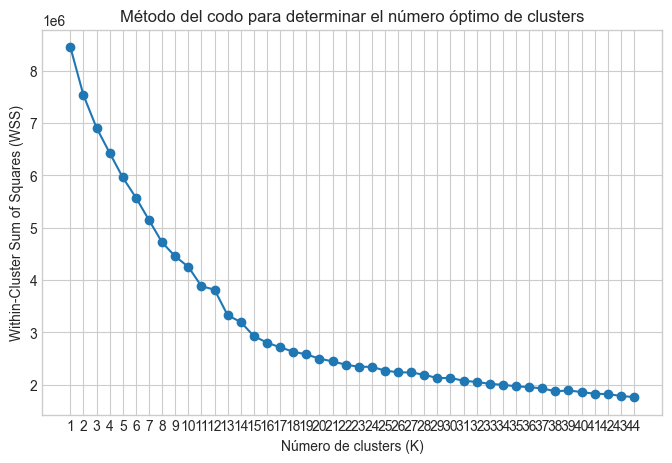

In [69]:
wss = []
K_range = range(1, 45)
for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42)
    kmeans_tmp.fit(df_encoded_scaled)
    wss.append(kmeans_tmp.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wss, marker='o')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.xticks(K_range)
plt.grid(True)
plt.show()

Numero optimo de clusters según la metodologia: 9 clusters

c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 clusters: 0.3346


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 clusters: 0.2095


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 4 clusters: 0.1601


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 5 clusters: 0.1795


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 6 clusters: 0.1902


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 7 clusters: 0.1940


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 8 clusters: 0.2174


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 9 clusters: 0.2262


c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 10 clusters: 0.1912


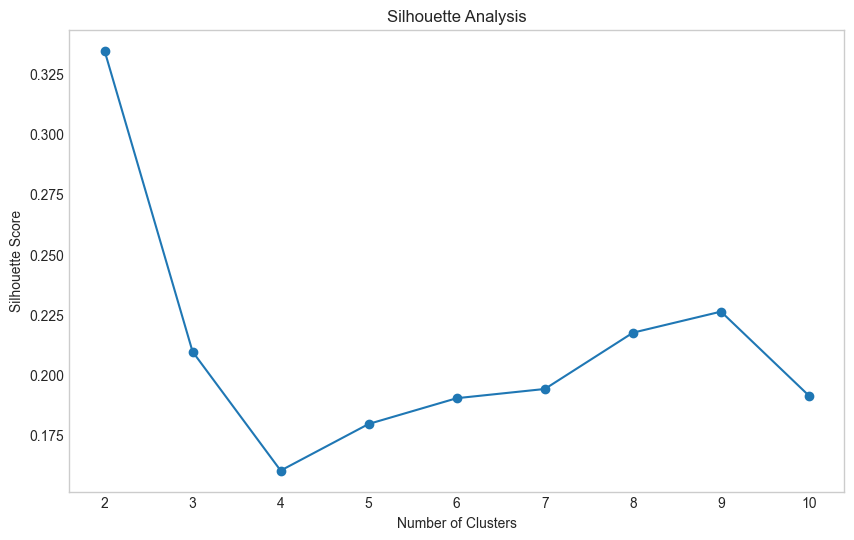

In [70]:
# Realizar silhouette analysis para determinar el número óptimo de clusters
from sklearn.metrics import silhouette_score
def silhouette_analysis(data, max_clusters=10):
    scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)
        scores.append(score)
        print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")
    return scores
silhouette_scores = silhouette_analysis(df_encoded_scaled, max_clusters=10)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

Numero optimo de clusters según la metodologia: 2 clusters

In [71]:
df_encoded_scaled_kmeans = df_encoded_scaled.copy()

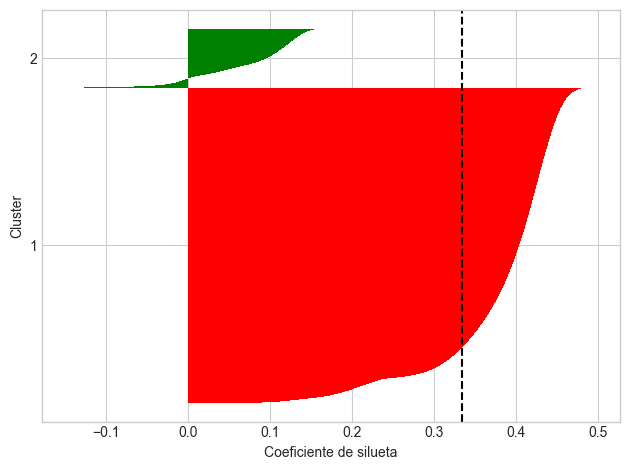

In [108]:
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabasz_score
k=2
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
kmeans.fit(df_encoded_scaled_kmeans)
y_clusters = kmeans.labels_
cluster_labels = np.unique(y_clusters)

silueta_puntos= silhouette_samples(df_encoded_scaled_kmeans, y_clusters, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
colores = ['r', 'g', 'b', 'y', 'c']
for i, c in enumerate(cluster_labels):
    silueta_puntos_c = silueta_puntos[y_clusters == c]
    silueta_puntos_c.sort()
    y_ax_upper += len(silueta_puntos_c)
    color = colores[i]
    plt.barh(range(y_ax_lower, y_ax_upper), silueta_puntos_c, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(silueta_puntos_c)
    
silueta_promedio = np.mean(silueta_puntos)
plt.axvline(silueta_promedio, color="black", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Coeficiente de silueta')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

In [73]:
CHs = []
for i in range(2,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_encoded_scaled_kmeans)
    CH = calinski_harabasz_score(df_encoded_scaled_kmeans, km.labels_) 
    CHs.append(CH)
CHs

c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from

[44886.24430228389,
 41114.4953595119,
 38715.197627108515,
 38454.650462891695,
 39247.95830301152,
 40382.623913241805,
 41652.12464680733,
 37160.477908526176,
 39531.66888498917,
 43248.26098850287,
 42437.502755430665,
 46006.57475087738,
 45732.10097428098]

In [74]:
# Imprimir CHs en orden junto con el número de clusters
for i, ch in enumerate(CHs, start=2):
    print(f"Clusters: {i}, Calinski-Harabasz Score: {ch:.4f}")

Clusters: 2, Calinski-Harabasz Score: 44886.2443
Clusters: 3, Calinski-Harabasz Score: 41114.4954
Clusters: 4, Calinski-Harabasz Score: 38715.1976
Clusters: 5, Calinski-Harabasz Score: 38454.6505
Clusters: 6, Calinski-Harabasz Score: 39247.9583
Clusters: 7, Calinski-Harabasz Score: 40382.6239
Clusters: 8, Calinski-Harabasz Score: 41652.1246
Clusters: 9, Calinski-Harabasz Score: 37160.4779
Clusters: 10, Calinski-Harabasz Score: 39531.6689
Clusters: 11, Calinski-Harabasz Score: 43248.2610
Clusters: 12, Calinski-Harabasz Score: 42437.5028
Clusters: 13, Calinski-Harabasz Score: 46006.5748
Clusters: 14, Calinski-Harabasz Score: 45732.1010


Numero optimo de clusters según la metodologia: 13 clusters

In [109]:
#df_encoded_scaled_kmeans = df_encoded_scaled.copy()
# Entrenar KMeans en todo el dataset
n_clusters = 13
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(df_encoded_scaled_kmeans)

# Obtener etiquetas y centroides
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Calcular distancias y definir umbral de anomalía
distances = np.linalg.norm(df_encoded_scaled_kmeans - centers[labels, :], axis=1)
dist_threshold = np.percentile(distances, 95)

# Detectar anomalías en el dataset completo
anomalies = np.sum(distances > dist_threshold)
print('KMeans clustering detected anomalies:', anomalies)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled_kmeans)

c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans clustering detected anomalies: 18381


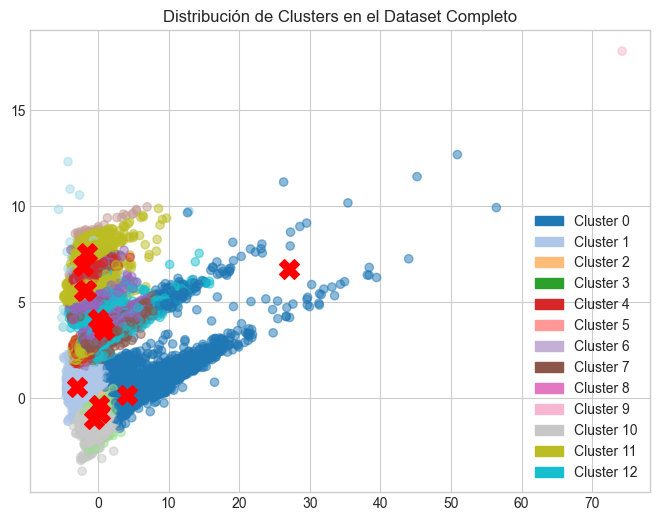

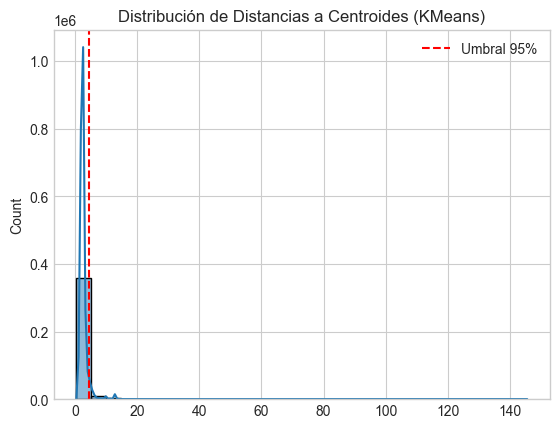

In [113]:
# Visualización de clusters
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='tab20', alpha=0.5)
plt.scatter(pca.transform(centers)[:, 0], pca.transform(centers)[:, 1], c='red', marker='X', s=200, label='Centroides')
plt.title('Distribución de Clusters en el Dataset Completo')
unique_labels = set(labels)
handles = [mpatches.Patch(color=plt.cm.tab20(i/13), label=f'Cluster {i}') for i in unique_labels]
plt.legend(handles=handles)
plt.show()

# Histograma de distancias
sns.histplot(distances, bins=30, kde=True)
plt.axvline(dist_threshold, color='red', linestyle='dashed', label='Umbral 95%')
plt.legend()
plt.title('Distribución de Distancias a Centroides (KMeans)')
plt.show()

In [114]:
# Asignar etiquetas de cluster a df_encoded
df_encoded_copy = df_encoded.copy()
df_encoded_copy['grupo'] = kmeans.labels_  # etiquetas del modelo
df_encoded_copy.groupby('grupo').describe()

DurationInSeconds                                                      \
                  count          mean           std    min      25%     50%   
grupo                                                                         
0               31106.0   7962.712146   4475.871267  619.0  5706.00  6733.0   
1               45827.0    852.711698   1133.541504    1.0    94.00   367.0   
2              106254.0   2653.721290   1365.729355   13.0  1690.00  2647.0   
3               94250.0   2848.173326   1336.877797   15.0  1903.00  2823.0   
4                2621.0   1673.465853   1338.000521    5.0   587.00  1324.0   
5                9714.0   3228.966234   2021.060426    1.0  1920.00  3000.0   
6               10703.0   3581.140989   2529.387934   12.0  1994.00  3179.0   
7                 110.0   2541.063636   2646.969270   85.0   882.25  1759.0   
8                   3.0    465.666667    604.938289    6.0   123.00   240.0   
9               58096.0   2229.789280   1308.459242    5.0  1202.00  2147.0   
10               4997.0   3116.149089   2705.984133    2.0  1361.00  2695.0   
11               3900.0   3811.003077   3520.144596    1.0  1906.75  3168.0   
12                 24.0  12158.333333  23285.087857   18.0  1838.25  3870.0   

                        DistanceInMeters                 ...  \
           75%      max            count           mean  ...   
grupo                                                    ...   
0      8488.00  95739.0          31106.0   20201.419791  ...   
1      1175.00  20463.0          45827.0    2186.090711  ...   
2      3602.00  22255.0         106254.0    7011.655096  ...   
3      3690.75  21645.0          94250.0    7601.118743  ...   
4      2540.00  12758.0           2621.0    4441.333997  ...   
5      4078.00  38340.0           9714.0    8319.487325  ...   
6      4494.50  27339.0          10703.0    9045.901073  ...   
7      2774.25  12683.0            110.0    6146.922560  ...   
8       695.50   1151.0              3.0  428266.443333  ...   
9      3069.00  22778.0          58096.0    5988.628575  ...   
10     4091.00  71974.0           4997.0    7224.824372  ...   
11     4604.25  50606.0           3900.0    8876.575967  ...   
12     7392.75  81900.0             24.0      15.518750  ...   

      TerrainType_Mixed      TerrainType_Uphill                                \
                    75%  max              count      mean       std  min  25%   
grupo                                                                           
0                   1.0  1.0            31106.0  0.000032  0.005670  0.0  0.0   
1                   0.0  0.0            45827.0  0.000000  0.000000  0.0  0.0   
2                   1.0  1.0           106254.0  0.000000  0.000000  0.0  0.0   
3                   1.0  1.0            94250.0  0.000000  0.000000  0.0  0.0   
4                   0.0  0.0             2621.0  0.000000  0.000000  0.0  0.0   
5                   1.0  1.0             9714.0  0.036854  0.188413  0.0  0.0   
6                   1.0  1.0            10703.0  0.008035  0.089282  0.0  0.0   
7                   0.0  0.0              110.0  0.472727  0.501541  0.0  0.0   
8                   0.5  1.0                3.0  0.000000  0.000000  0.0  0.0   
9                   1.0  1.0            58096.0  0.000000  0.000000  0.0  0.0   
10                  0.0  1.0             4997.0  0.311587  0.463188  0.0  0.0   
11                  1.0  1.0             3900.0  0.044359  0.205918  0.0  0.0   
12                  0.0  1.0               24.0  0.000000  0.000000  0.0  0.0   

                      
       50%  75%  max  
grupo                 
0      0.0  0.0  1.0  
1      0.0  0.0  0.0  
2      0.0  0.0  0.0  
3      0.0  0.0  0.0  
4      0.0  0.0  0.0  
5      0.0  0.0  1.0  
6      0.0  0.0  1.0  
7      0.0  1.0  1.0  
8      0.0  0.0  0.0  
9      0.0  0.0  0.0  
10     0.0  1.0  1.0  
11     0.0  0.0  1.0  
12     0.0  0.0  0.0  

[13 rows x 136 columns]

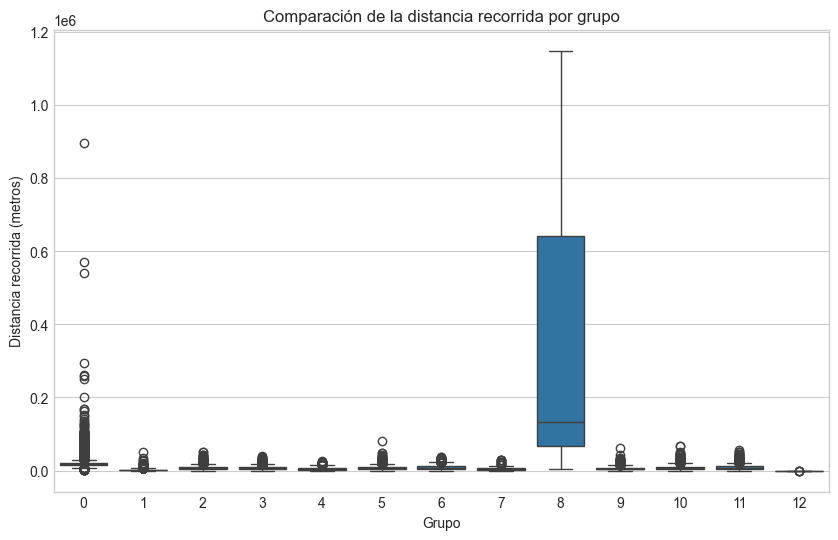

In [115]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grupo', y='DistanceInMeters', data=df_encoded_copy)
plt.title('Comparación de la distancia recorrida por grupo')
plt.xlabel('Grupo')
plt.ylabel('Distancia recorrida (metros)')
plt.show()

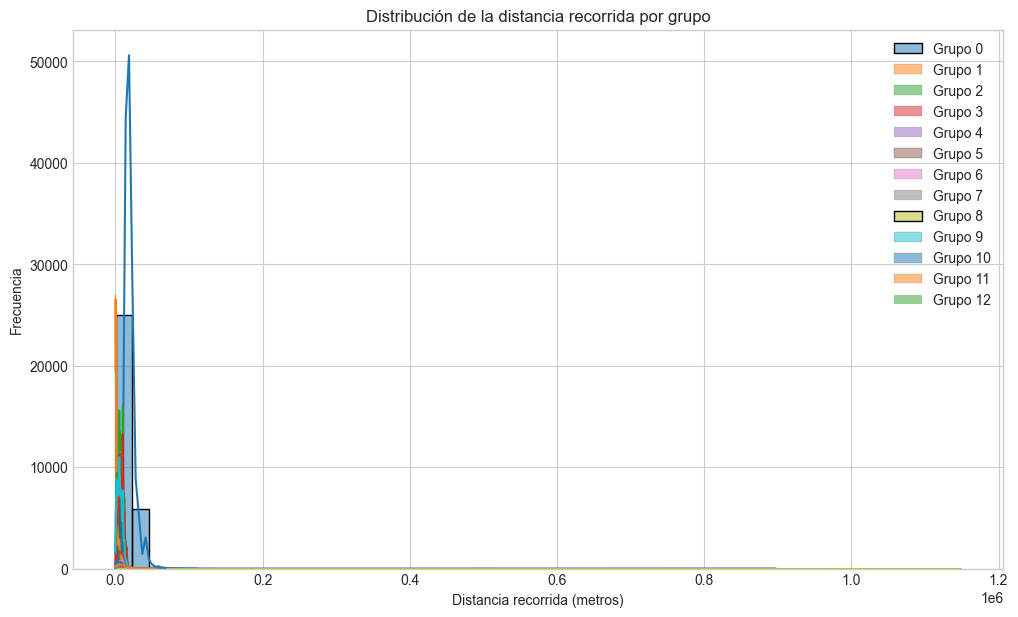

In [116]:
plt.figure(figsize=(12, 7))
for grupo in sorted(df_encoded_copy['grupo'].unique()):
    sns.histplot(df_encoded_copy[df_encoded_copy['grupo'] == grupo]['DistanceInMeters'], 
                 label=f'Grupo {grupo}', kde=True, bins=40, alpha=0.5)
plt.title('Distribución de la distancia recorrida por grupo')
plt.xlabel('Distancia recorrida (metros)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

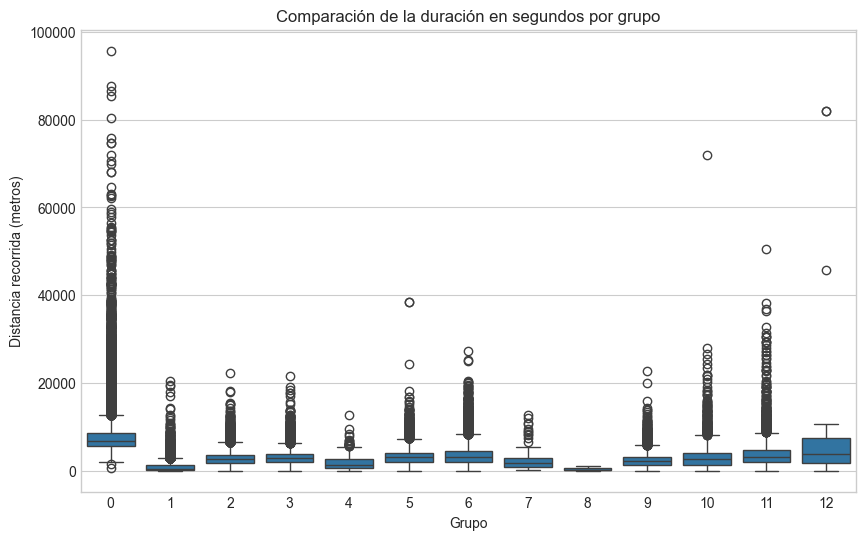

In [120]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grupo', y='DurationInSeconds', data=df_encoded_copy)
plt.title('Comparación de la duración en segundos por grupo')
plt.xlabel('Grupo')
plt.ylabel('Distancia recorrida (metros)')
plt.show()

In [118]:
# Obtener los índices de las anomalías detectadas en el dataset completo
anomaly_indices_kmeans = np.where(distances > dist_threshold)[0]

# Recuperar los valores originales de df_encoded (desestandarizados)
df_original_kmeans = scaler.inverse_transform(df_encoded_scaled_kmeans)

# Convertir de nuevo a DataFrame con los nombres originales de columnas
df_original_kmeans = pd.DataFrame(df_original_kmeans, columns=df_encoded.columns, index=df_encoded.index)

# Mostrar los primeros registros anómalos en su escala original
df_original_kmeans.iloc[anomaly_indices_kmeans].head(10)

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,...,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo
9,4508.0,15026.559570,8479.2,3.333,74.6,5.684342e-14,-18000.0,2025.0,2.0,28.0,...,0.0,1.0,0.0,0.0,5.421011e-20,0.0,0.0,0.0,0.0,1.0
19,1478.0,6011.740000,4322.0,4.069,146.0,3.820000e+02,32400.0,2025.0,3.0,1.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
31,2276.0,6595.430000,6262.0,2.898,103.0,3.430000e+02,32400.0,2025.0,3.0,1.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
40,2705.0,7835.520020,8021.6,2.897,121.6,5.684342e-14,-18000.0,2025.0,2.0,28.0,...,0.0,1.0,0.0,0.0,5.421011e-20,0.0,0.0,0.0,0.0,1.0
43,1502.0,4498.280000,8.0,2.994,123.0,2.320000e+02,32400.0,2025.0,3.0,1.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
101,1579.0,3362.710000,4220.0,2.130,134.0,2.270000e+02,32400.0,2025.0,3.0,1.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
103,2846.0,6322.569824,5988.6,2.222,110.0,5.684342e-14,-10800.0,2025.0,2.0,28.0,...,0.0,1.0,0.0,0.0,5.421011e-20,0.0,0.0,0.0,0.0,1.0
147,1801.0,4847.470000,4894.0,2.691,119.0,3.290000e+02,32400.0,2025.0,3.0,1.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
153,13325.0,32578.050000,33160.0,2.445,148.0,2.622000e+03,-18000.0,2025.0,2.0,23.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0
181,20337.0,18262.070000,4350.0,0.898,77.0,1.448000e+03,-18000.0,2025.0,2.0,28.0,...,0.0,0.0,1.0,0.0,5.421011e-20,0.0,1.0,0.0,0.0,0.0


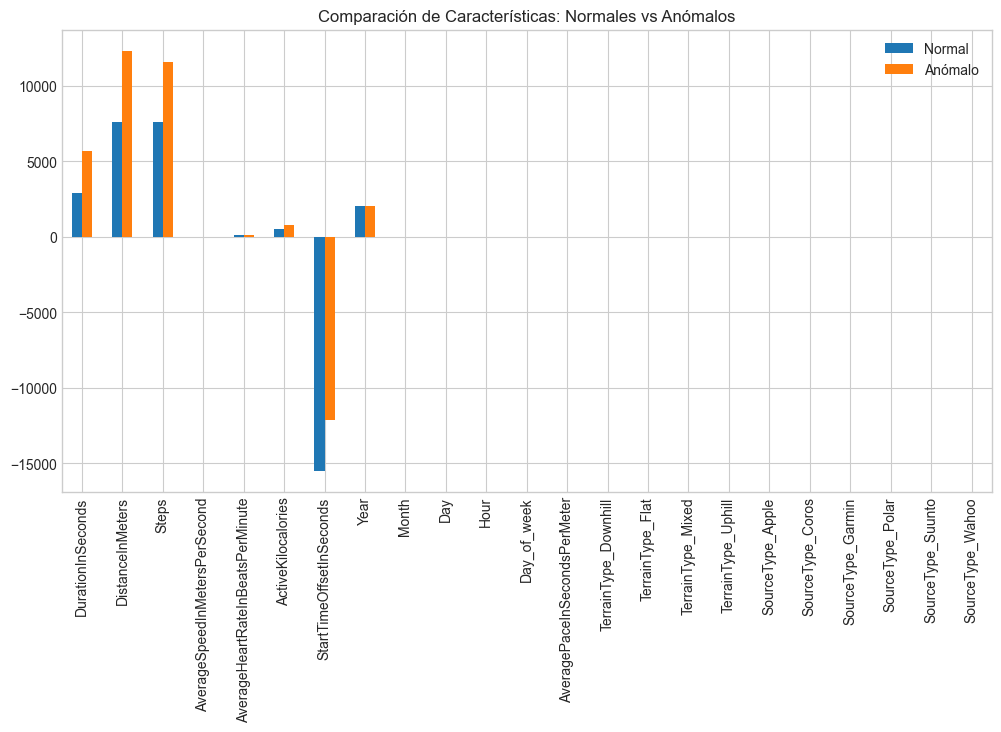

In [121]:
# Recuperar los valores originales de las anomalías detectadas
anomalies_df = df_original_kmeans.iloc[anomaly_indices_kmeans]

# Calcular la media de las anomalías y la media de todo el dataset
anomalies_mean = anomalies_df.mean()
normal_mean = df_original_kmeans.mean()

# Comparar anomalías vs. valores normales
pd.DataFrame({'Normal': normal_mean, 'Anómalo': anomalies_mean}).plot(kind='bar', figsize=(12,6), title='Comparación de Características: Normales vs Anómalos')
plt.show()

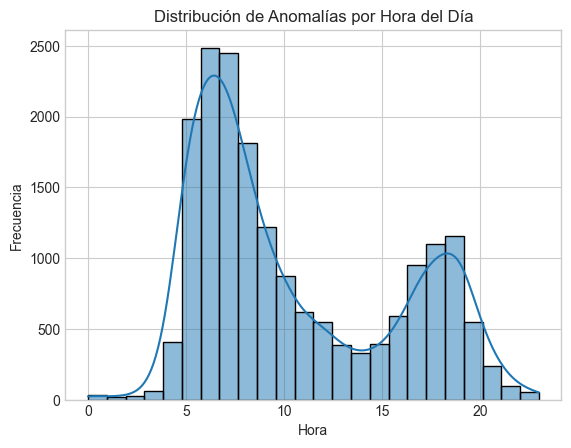

In [122]:
# Filtrar anomalías en el dataset completo
df_anomalies = df_encoded.iloc[anomaly_indices_kmeans]
sns.histplot(df_anomalies['Hour'], bins=24, kde=True)
plt.title('Distribución de Anomalías por Hora del Día')
plt.xlabel('Hora')
plt.ylabel('Frecuencia')
plt.show()

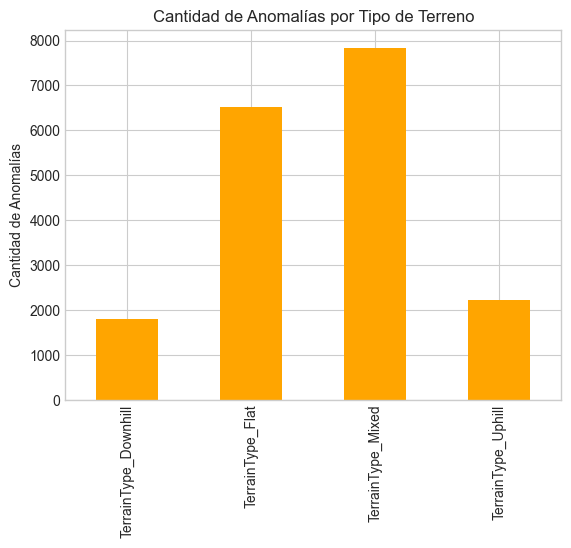

In [123]:
terrain_cols = ['TerrainType_Downhill', 'TerrainType_Flat', 'TerrainType_Mixed', 'TerrainType_Uphill']
# Sumar anomalías por tipo de terreno en todo el dataset
anomalies_by_terrain = df_anomalies[terrain_cols].sum()

# Graficar la cantidad de anomalías por tipo de terreno
anomalies_by_terrain.plot(kind='bar', color='orange', title='Cantidad de Anomalías por Tipo de Terreno')
plt.ylabel('Cantidad de Anomalías')
plt.show()

In [124]:
device_cols = ['SourceType_Apple', 'SourceType_Coros', 'SourceType_Garmin', 'SourceType_Polar', 'SourceType_Suunto', 'SourceType_Wahoo']

# Tabla cruzada de anomalías por dispositivo y tipo de terreno en todo el dataset
anomalies_cross = df_anomalies.groupby(device_cols + terrain_cols).size().reset_index(name='count')

# Mostrar los primeros casos ordenados por cantidad de anomalías
anomalies_cross.sort_values('count', ascending=False).head(10)

,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,count
13,False,False,True,False,False,False,0.0,0.0,1.0,0.0,5910
2,False,False,False,False,False,True,0.0,1.0,0.0,0.0,3287
14,False,False,True,False,False,False,0.0,1.0,0.0,0.0,1420
10,False,False,False,True,False,False,0.0,1.0,0.0,0.0,826
17,False,True,False,False,False,False,0.0,0.0,1.0,0.0,821
0,False,False,False,False,False,True,0.0,0.0,0.0,1.0,779
12,False,False,True,False,False,False,0.0,0.0,0.0,1.0,767
15,False,False,True,False,False,False,1.0,0.0,0.0,0.0,633
11,False,False,False,True,False,False,1.0,0.0,0.0,0.0,569
6,False,False,False,False,True,False,0.0,1.0,0.0,0.0,541


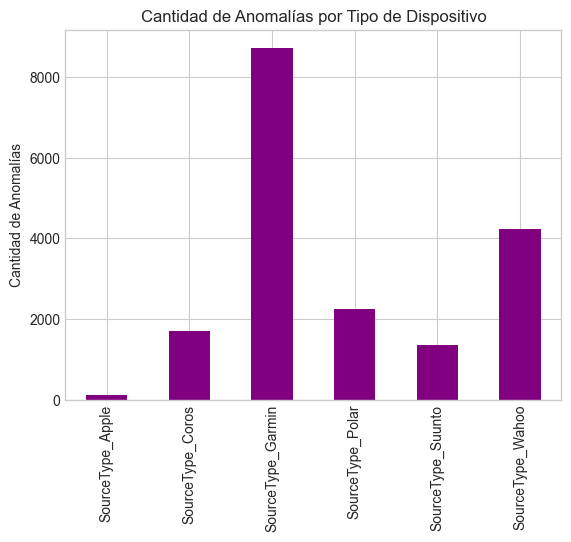

In [125]:
# Sumar anomalías por tipo de dispositivo en todo el dataset
anomalies_by_device = df_anomalies[device_cols].sum()

# Graficar la cantidad de anomalías por tipo de dispositivo
anomalies_by_device.plot(kind='bar', color='purple', title='Cantidad de Anomalías por Tipo de Dispositivo')
plt.ylabel('Cantidad de Anomalías')
plt.show()

## DBSCAN

Density-Based Spatial Clustering of Applications with Noise es un algoritmo de clustering que agrupa puntos en función de su densidad y será usado para el proceso de identificación de datos atípicos

In [88]:
df_encoded_scaled_dbscan = df_encoded_scaled.copy()

In [89]:
eps_values=[0.1, 0.2, 0.3, 0.4, 0.5]
min_samples_values=[5, 10, 15, 20]

In [90]:
# Aplicar Harabasz Score para determinar el número óptimo de clusters
from sklearn.metrics import calinski_harabasz_score
def harabasz_analysis_dbscan(data, eps_values, min_samples_values):
    scores = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            cluster_labels = dbscan.fit_predict(data)
            if len(set(cluster_labels)) > 1:  # Al menos dos clusters
                score = calinski_harabasz_score(data, cluster_labels)
                scores.append((eps, min_samples, score))
                print(f"Calinski-Harabasz Score for eps={eps}, min_samples={min_samples}: {score:.4f}")
    return scores
harabasz_scores_dbscan = harabasz_analysis_dbscan(df_encoded_scaled_dbscan, eps_values, min_samples_values)
# Imprimir Harabasz Scores en orden junto con el número de clusters
for eps, min_samples, score in harabasz_scores_dbscan:
    print(f"eps: {eps}, min_samples: {min_samples}, Calinski-Harabasz Score: {score:.4f}")

Calinski-Harabasz Score for eps=0.1, min_samples=5: 8.2398
Calinski-Harabasz Score for eps=0.1, min_samples=10: 11.2302
Calinski-Harabasz Score for eps=0.2, min_samples=5: 7.5416
Calinski-Harabasz Score for eps=0.2, min_samples=10: 13.3396
Calinski-Harabasz Score for eps=0.2, min_samples=15: 18.2236
Calinski-Harabasz Score for eps=0.3, min_samples=5: 6.1229
Calinski-Harabasz Score for eps=0.3, min_samples=10: 10.2868
Calinski-Harabasz Score for eps=0.3, min_samples=15: 19.5768
Calinski-Harabasz Score for eps=0.3, min_samples=20: 27.9616
Calinski-Harabasz Score for eps=0.4, min_samples=5: 13.2432
Calinski-Harabasz Score for eps=0.4, min_samples=10: 20.9811
Calinski-Harabasz Score for eps=0.4, min_samples=15: 20.0463
Calinski-Harabasz Score for eps=0.4, min_samples=20: 17.3818
Calinski-Harabasz Score for eps=0.5, min_samples=5: 30.7946
Calinski-Harabasz Score for eps=0.5, min_samples=10: 54.0989
Calinski-Harabasz Score for eps=0.5, min_samples=15: 72.3465
Calinski-Harabasz Score for eps=

In [91]:
dbscan = DBSCAN(eps=0.4, min_samples=9, metric='manhattan')
df_encoded_scaled_dbscan = pd.DataFrame(df_encoded_scaled_dbscan, columns=df_encoded.columns)

dbscan.fit(df_encoded_scaled_dbscan)

cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame using .loc
df_encoded_scaled_dbscan.loc[:, 'cluster_labels'] = cluster_labels

display(df_encoded_scaled_dbscan.head())

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,cluster_labels
0,-0.248551,-0.386837,-0.277113,-0.229424,0.296469,-0.503043,-0.510311,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
1,-0.721652,-0.796892,-0.761490,-0.245996,-1.982953,-0.925611,0.221833,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
2,0.082385,0.359173,0.201300,0.168315,-0.286639,0.354031,0.953976,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
3,-0.434189,-0.357565,-0.402680,0.048670,-0.021590,-0.553178,0.221833,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
4,-0.866168,-0.845912,-0.951994,0.027651,-0.816737,-0.896962,-0.510311,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1


Silhouette Score promedio para DBSCAN: 0.636


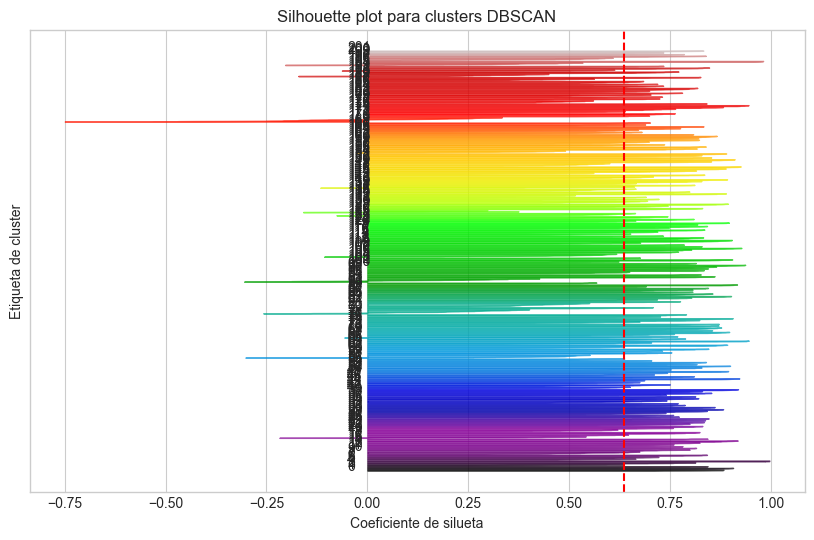

In [92]:
from sklearn.metrics import silhouette_score, silhouette_samples

# Filtrar solo los puntos que no son ruido (-1)
mask = df_encoded_scaled_dbscan['cluster_labels'] != -1
X_clusters = df_encoded_scaled_dbscan.loc[mask].drop(columns=['cluster_labels'])
labels_clusters = df_encoded_scaled_dbscan.loc[mask, 'cluster_labels']

# Calcular la métrica de silueta
silhouette_avg = silhouette_score(X_clusters, labels_clusters)
sample_silhouette_values = silhouette_samples(X_clusters, labels_clusters)

print(f"Silhouette Score promedio para DBSCAN: {silhouette_avg:.3f}")

import matplotlib.cm as cm

n_clusters_dbscan = len(set(labels_clusters))
fig, ax1 = plt.subplots(figsize=(10, 6))

y_lower = 10
for i, cluster in enumerate(sorted(set(labels_clusters))):
    ith_cluster_silhouette_values = sample_silhouette_values[labels_clusters == cluster]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters_dbscan)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster))
    y_lower = y_upper + 10

ax1.set_title("Silhouette plot para clusters DBSCAN")
ax1.set_xlabel("Coeficiente de silueta")
ax1.set_ylabel("Etiqueta de cluster")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
plt.show()

Con la configuración utilizada para DBSCAN se obtiene la gráfica de silueta mostrada anteriormente. Aunque esta configuración no ofrece un resultado óptimo, logra reducir al mínimo la cantidad de clusters con un coeficiente de silueta negativo.

PCA en 2 dimensiones

In [93]:

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded_scaled_dbscan.drop(columns=['cluster_labels']))

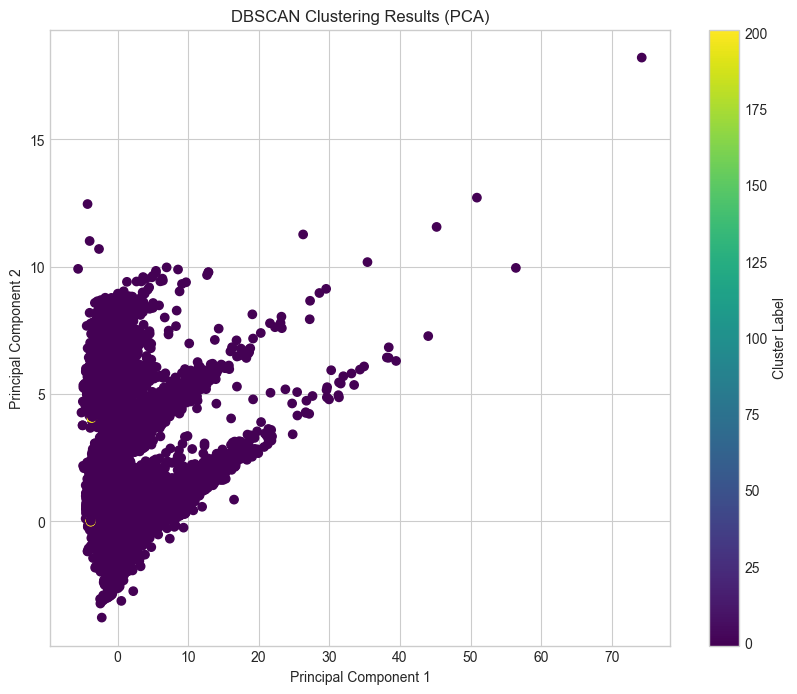

In [94]:
# Create a scatter plot of the data points, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_encoded_scaled_dbscan['cluster_labels'], cmap='viridis')
plt.title('DBSCAN Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

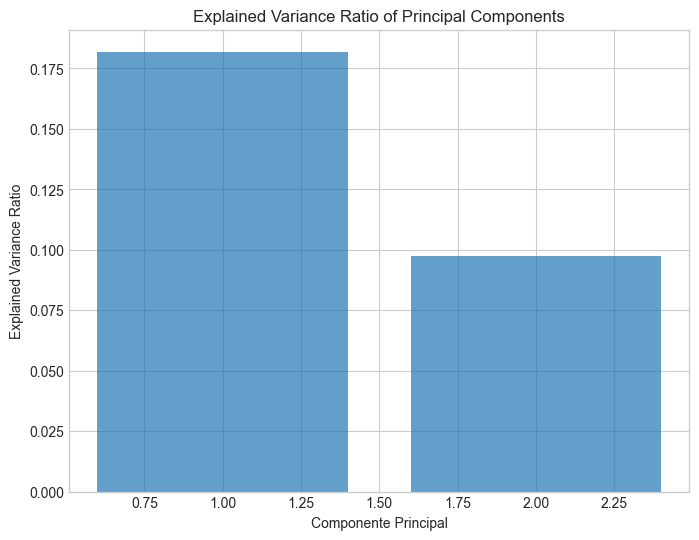

In [95]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Componente Principal')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [96]:
from mpl_toolkits.mplot3d import Axes3D

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_encoded_scaled_dbscan.drop(columns=['cluster_labels']))

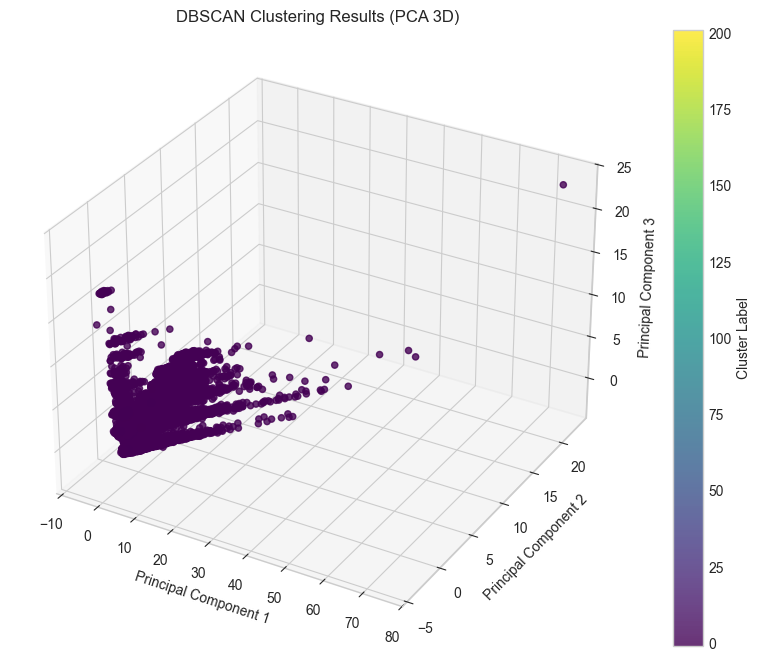

In [97]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos con sus clusters
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2],
                     c=df_encoded_scaled_dbscan['cluster_labels'], cmap='viridis', alpha=0.8)

ax.set_title('DBSCAN Clustering Results (PCA 3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.colorbar(scatter, label="Cluster Label")
plt.show()

- Si los puntos forman grupos definidos, significa que DBSCAN ha encontrado patrones claros en los datos. En este caso no es muy evidente

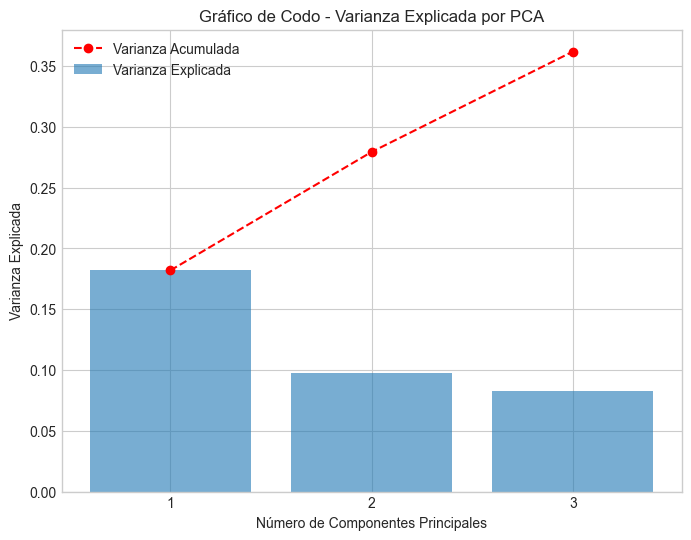

In [98]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Suma acumulada

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza Explicada')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label='Varianza Acumulada')

plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Gráfico de Codo - Varianza Explicada por PCA')
plt.legend()
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

- Las barras azules representan la varianza explicada por cada componente principal.
- La línea roja punteada muestra la varianza acumulada a medida que se agregan más componentes.

In [99]:
# Cantidad de clusters detectados por DBSCAN
n_clusters_dbscan = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f"DBSCAN detected {n_clusters_dbscan} clusters.")

DBSCAN detected 202 clusters.


In [100]:
anomalies = df_encoded_scaled_dbscan[df_encoded_scaled_dbscan['cluster_labels'] == -1]
anomalies.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,cluster_labels
0,-0.248551,-0.386837,-0.277113,-0.229424,0.296469,-0.503043,-0.510311,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
1,-0.721652,-0.796892,-0.761490,-0.245996,-1.982953,-0.925611,0.221833,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
2,0.082385,0.359173,0.201300,0.168315,-0.286639,0.354031,0.953976,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
3,-0.434189,-0.357565,-0.402680,0.048670,-0.021590,-0.553178,0.221833,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
4,-0.866168,-0.845912,-0.951994,0.027651,-0.816737,-0.896962,-0.510311,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1


In [101]:
print('DBSCAN detected anomalies:', len(anomalies))

DBSCAN detected anomalies: 364881


## SVM

In [102]:
df_encoded_scaled_svm = df_encoded_scaled.copy()

# 2. One-Class SVM
one_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.02)
one_svm.fit(df_encoded_scaled_svm)
svm_pred = one_svm.predict(df_encoded_scaled_svm)
svm_anomalies = np.sum(svm_pred == -1)
print('One-Class SVM detected anomalies:', svm_anomalies)


One-Class SVM detected anomalies: 7347


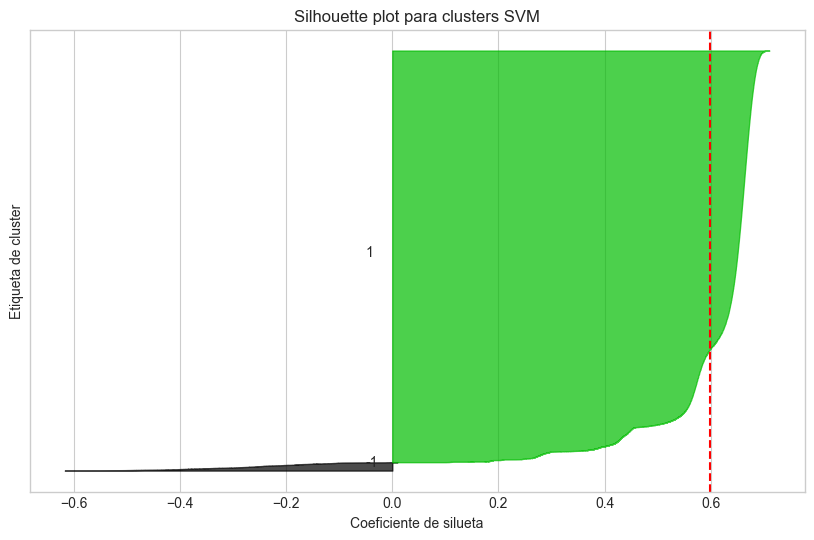

In [103]:
# Filtrar solo los datos normales y anómalos
X_svm = df_encoded_scaled_svm
labels_svm = svm_pred

# Calcular la métrica de silueta (solo si hay más de 1 cluster)
if len(np.unique(labels_svm)) > 1:
    silhouette_avg = silhouette_score(X_svm, labels_svm)
    sample_silhouette_values = silhouette_samples(X_svm, labels_svm)

    import matplotlib.cm as cm

    n_clusters_svm = len(np.unique(labels_svm))
    fig, ax1 = plt.subplots(figsize=(10, 6))

    y_lower = 10
    for i, cluster in enumerate(sorted(np.unique(labels_svm))):
        ith_cluster_silhouette_values = sample_silhouette_values[labels_svm == cluster]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters_svm)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(cluster))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot para clusters SVM")
    ax1.set_xlabel("Coeficiente de silueta")
    ax1.set_ylabel("Etiqueta de cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    plt.show()
else:
    print("No hay suficientes clusters para calcular la métrica de silueta.")

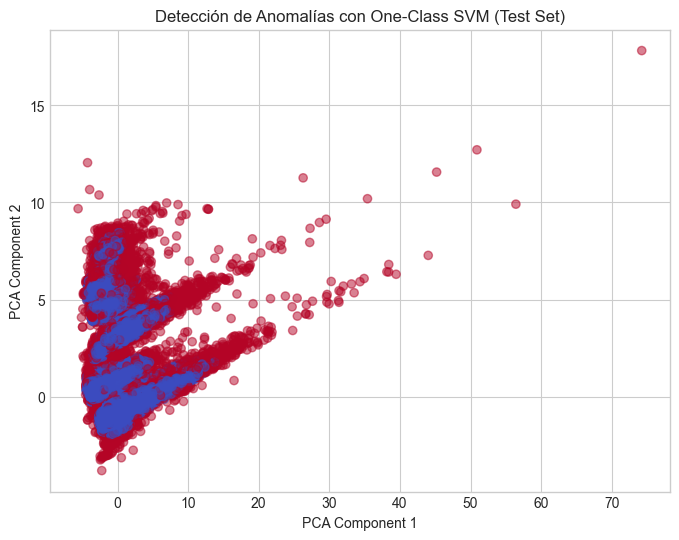

In [104]:
# Scatter plot con anomalías detectadas en el conjunto de prueba
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_encoded_scaled_svm)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=(svm_pred == -1), cmap='coolwarm', alpha=0.5)
plt.title('Detección de Anomalías con One-Class SVM (Test Set)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Isolation Forest Model

c:\Users\Laura Chaparro\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


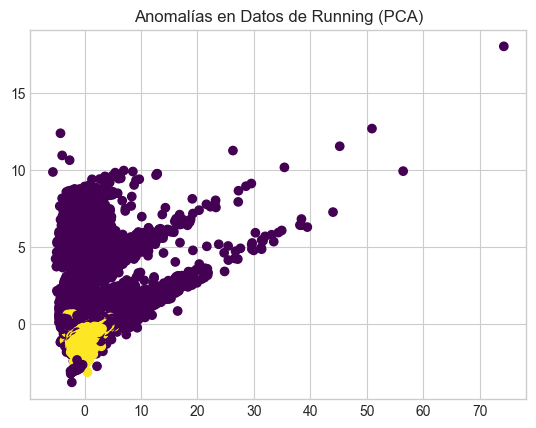

In [105]:
df_encoded_scaled_ifm = df_encoded_scaled.copy()
df_encoded_scaled_ifm = pd.DataFrame(df_encoded_scaled_ifm, columns=df_encoded.columns)

modelo = IsolationForest(
    n_estimators=100, 
    contamination=0.2,  # Asume un 20% de anomalías
    random_state=42
)
modelo.fit(df_encoded_scaled_ifm)  # No se usan etiquetas (y_label)
df_encoded_scaled_ifm['isAnomaly'] = modelo.predict(df_encoded_scaled_ifm)  # 1 = normal, -1 = anomalía

datos_anomalos = df_encoded_scaled_ifm[df_encoded_scaled_ifm['isAnomaly'] == -1]


# Reducir a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_encoded_scaled_ifm.drop(columns='isAnomaly'))

# Graficar
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_encoded_scaled_ifm['isAnomaly'], cmap='viridis')
plt.title('Anomalías en Datos de Running (PCA)')
plt.show()

In [106]:
print('Isolation Forest detected anomalies: ', len(datos_anomalos))

Isolation Forest detected anomalies:  73521


In [107]:
datos_anomalos.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AverageHeartRateInBeatsPerMinute,ActiveKilocalories,StartTimeOffsetInSeconds,Year,Month,Day,...,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,SourceType_Apple,SourceType_Coros,SourceType_Garmin,SourceType_Polar,SourceType_Suunto,SourceType_Wahoo,isAnomaly
0,-0.248551,-0.386837,-0.277113,-0.229424,0.296469,-0.503043,-0.510311,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
1,-0.721652,-0.796892,-0.761490,-0.245996,-1.982953,-0.925611,0.221833,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
5,-0.519174,-0.165351,-0.528247,0.532909,1.144626,-0.271466,-0.510311,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,0.302462,-0.170115,-0.106268,-0.107841,-1
9,0.623632,1.117432,0.143851,0.222883,-3.594451,-1.202548,-0.510311,1.087303,-1.043604,1.406626,...,2.427129,-2.305838,-0.078071,-0.017301,-0.183944,-3.306201,-0.170115,-0.106268,9.272891,-1
24,0.123507,0.362675,0.204116,0.129107,0.031420,0.201238,-0.510311,1.087303,-1.043604,1.406626,...,-0.412009,0.433682,-0.078071,-0.017301,5.436434,-3.306201,-0.170115,-0.106268,-0.107841,-1


### Conclusiones de modelamiento

- Resultados generales de cada modelo:
    - KMeans clustering detected anomalies: 18381
    - DBSCAN detected anomalies: 364881
    - One-Class SVM detected anomalies: 7347
    - Isolation Forest detected anomalies:  73521

- A partir del modelo de K-Means, se identificaron 18381 registros atípicos. Estos fueron detectados al analizar los datos que se alejan significativamente de su centroide. Para determinar las anomalías, se consideraron como outliers aquellos puntos cuya distancia al centroide superaba el percentil 95, marcando así el 5% de los puntos más alejados de su cluster. Además, se observó que los registros atípicos se presentaban principalmente en terrenos flat y mixed, con mayor porcentaje en mixed. En cuanto a los dispositivos, Garmin fue el que registró la mayor cantidad de datos atípicos. La hora con mayor presencia de anomalías fue las entre las 6:00 y 7:00 AM. Al analizar la combinación de terreno y dispositivo, se identificó que la mayor cantidad de registros atípicos correspondía a Garmin en terreno Mixed. 

- Al analizar los clusters generados por K-Means, se observa que los clusters 0 y 8 presentan altos valores de distancia, destacando especialmente el cluster 0, donde se identifican posibles valores atípicos. Además, tanto en el cluster 0 como en el 12 se evidencian valores inusuales en la métrica de duración.

- DBSCAN detectó la mayor cantidad de atípicos, acercándose al total de los datos, lo cual sugiere que la configuración actual del modelo no es adecuada y requiere ajustes para obtener resultados más precisos.

- Isolation Forest depende del porcentaje de anomalías esperado dentro del conjunto de datos, lo que significa que al aumentar este valor, también se incrementa la cantidad de datos detectados como atípicos. Por lo tanto, al establecer el parámetro de contamination en 0.2, estamos indicando que se espera que el 20% de los datos sean anomalías.

## Conclusión

- Ante la pregunta smart: ¿Es posible identificar actividades de running atípicas o sospechosas con datos de los últimos 5 meses (10/2024 - 02/2025) utilizando métricas cómo velocidad, distancia, elevación, tiempo y frecuencia cardiaca?. Sí, es posible. El análisis de variables clave como velocidad, distancia, elevación, tiempo y frecuencia cardiaca permite detectar anomalías que podrían indicar errores de registro. La identificación de valores atípicos en métricas como la velocidad y la elevación sugiere que algunos registros presentan comportamientos inusuales que no siguen la distribución esperada. Sin embargo, es importante considerar que la presencia de valores atípicos no implica automáticamente fraude o actividad sospechosa. Factores como el tipo de terreno, las condiciones climáticas, la variabilidad en los dispositivos de medición y el estado físico del atleta pueden influir en los resultados y generar datos aparentemente anómalos sin que haya una alteración intencionada.